In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

### Data

In [15]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [16]:
tree_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [17]:
class DataFile(object):
    def __init__(self, path, name):
        self.path = path
        self.name = name
        self.raw = uproot.open(self.path)
    def features(self):
        return self.raw.keys()
    def true_features(self):
        return [name for name in self.raw.keys() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=aliases, library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [19]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [20]:
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [21]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [22]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [23]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [24]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [25]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [26]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [27]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [28]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          970116   247104  197683   49421       0.254716
B⁺→K⁺J/ψ(→ee)    960234   929755  743804  185951       0.968259
B⁺→K⁺ψ(2S)(→ee)  986271   939679  751743  187936       0.952759
D⁺→π⁺φ(→ee)      830027   830027  664021  166006            1.0

### KS tests

In [29]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [30]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [31]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
            density=True, histtype='step', bins=bins, **kwargs)
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

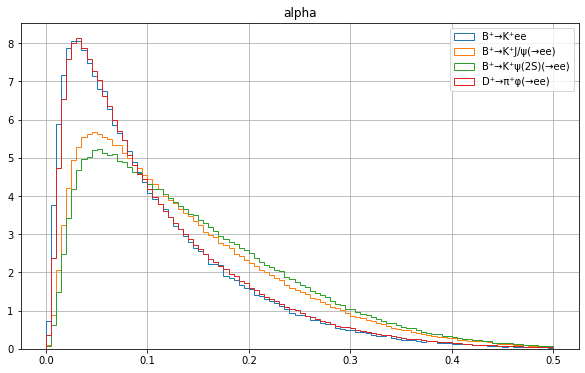

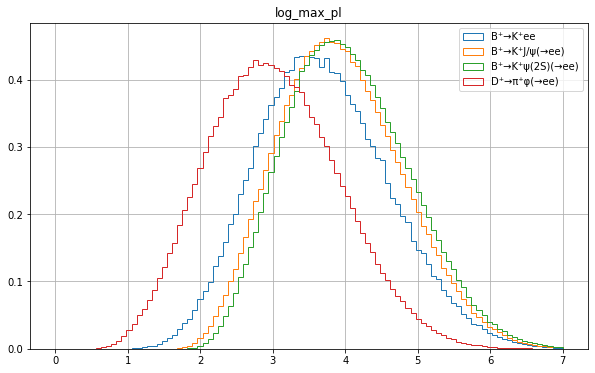

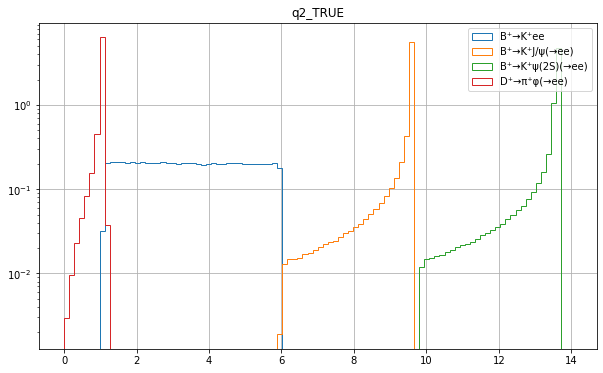

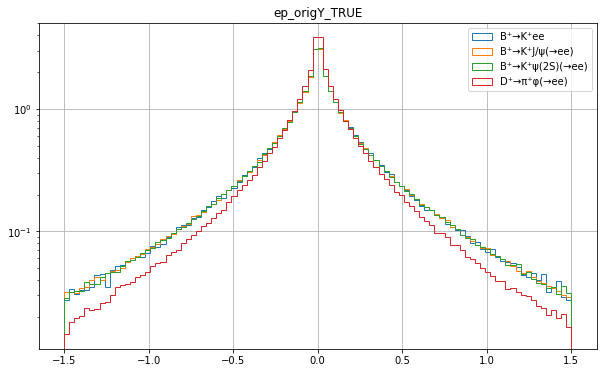

In [32]:
feature_plot("alpha", train_ds, aliases, np.linspace(0, 0.5, 101))
feature_plot("log_max_pl", train_ds, aliases, np.linspace(0, 7, 101))
feature_plot("q2_TRUE", train_ds, aliases, np.linspace(0, 14, 101), log=True)
feature_plot("ep_origY_TRUE", train_ds, aliases, np.linspace(-1.5, 1.5, 101), log=True)

### Preprocessing

In [33]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [34]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [35]:
feature_sets = [
    ("α", ["alpha"]),
    ("α,p", ["alpha", "log_max_pl"]),
    ("pt,pt", ["log_ep_PT", "log_em_PT"])
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

ds_a4 = Dataset(["alpha"], train_ds, aliases, "₄[α]")
ds_a3 = Dataset(["alpha"], train_ds[:3], aliases, "₃[α]")
ds_la4 = Dataset(["alpha", "log_max_pl"], train_ds, aliases, "₄[α,p]")
ds_la3 = Dataset(["alpha", "log_max_pl"], train_ds[:3], aliases, "₃[α,p]")
ds_pt4 = Dataset(["log_ep_PT", "log_em_PT"], train_ds, aliases, "₄[pt,pt]")
ds_pt3 = Dataset(["log_ep_PT", "log_em_PT"], train_ds[:3], aliases, "₃[pt,pt]")

In [36]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(to_numpy(dataset.X()))
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [37]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.inverse_transform(lower)[0]
    x_max, y_max = sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

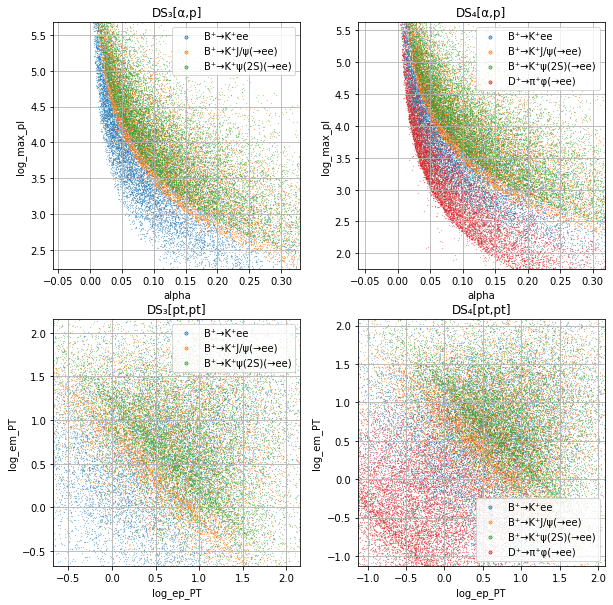

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_ds(ds_la3, scale=2.0, ax=ax[0,0])
plot_ds(ds_la4, scale=2.0, ax=ax[0,1])
plot_ds(ds_pt3, scale=2.0, ax=ax[1,0])
plot_ds(ds_pt4, scale=2.0, ax=ax[1,1])
plt.show()

### NN

In [39]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [40]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [41]:
def plot_one(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = dataset.inverse_transform([[-3.0], [3.0]])
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(dataset.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [42]:
class Estimator(object):
    def __init__(self, dataset):
        self.features = dataset.features
        self.scaler = Scaler(dataset)
        self.model = torch.nn.Sequential(
            self.scaler,
            model(len(dataset.features), len(dataset.sources))
        ).to(device)
    def train(self, dataset):
        assert dataset.features == self.features
        ds = torch.utils.data.TensorDataset(
            dataset.X(device=device, dtype=float),
            dataset.Y(device=device, dtype=torch.int64)
        )
        loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=dataset.weights, accumulate=False)
        loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=dataset.weights, accumulate=True)
        return self.model

In [43]:
def plot_field(f, scaler, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = scaler.inverse_transform(lower)[0]
    x_max, y_max = scaler.inverse_transform(upper)[0]
    
    sc1 = scale+1
    X_test = scaler.inverse_transform(np.asarray(bridson.poisson_disc_samples(2*sc1, 2*sc1, 0.02)) - sc1)
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(scaler.features[0])
    axis.set_ylabel(scaler.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [44]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    plot_field(f, scaler, scale=scale, name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]), ax=ax)

In [45]:
def plot_clf_min_max(clf, scaler, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    plot_field(as_numpy(f_min), scaler, scale=scale, name=r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None, ax=ax_min)
    plot_field(as_numpy(f_max), scaler, scale=scale, name=r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None, ax=ax_max)

In [46]:
%%time
e_a4 = Estimator(ds_a4)
e_a4.train(ds_a4)

INFO:root:Epoch 0, 1.388770
INFO:root:Epoch 1, 1.380602
INFO:root:Epoch 2, 1.375632
INFO:root:Epoch 3, 1.371257
INFO:root:Epoch 4, 1.368326
INFO:root:Epoch 5, 1.367101
INFO:root:Epoch 6, 1.366381
INFO:root:Epoch 7, 1.365821
INFO:root:Epoch 8, 1.365391
INFO:root:Epoch 9, 1.365070
INFO:root:Epoch 10, 1.364835
INFO:root:Epoch 11, 1.364688
INFO:root:Epoch 12, 1.364574
INFO:root:Epoch 13, 1.364490
INFO:root:Epoch 14, 1.364459
INFO:root:Epoch 15, 1.364410
INFO:root:Epoch 16, 1.364348
INFO:root:Epoch 17, 1.364292
INFO:root:Epoch 18, 1.364269
INFO:root:Epoch 19, 1.364239
INFO:root:Epoch 20, 1.364201
INFO:root:Epoch 21, 1.364168
INFO:root:Epoch 22, 1.364159
INFO:root:Epoch 23, 1.364139
INFO:root:Epoch 24, 1.364104
INFO:root:Epoch 25, 1.364087
INFO:root:Epoch 26, 1.364065
INFO:root:Epoch 27, 1.364066
INFO:root:Epoch 28, 1.364013
INFO:root:Epoch 29, 1.364000
INFO:root:Epoch 30, 1.363968
INFO:root:Epoch 31, 1.363954
INFO:root:Epoch 32, 1.363950
INFO:root:Epoch 33, 1.363904
INFO:root:Epoch 34, 1.36

CPU times: user 31.7 s, sys: 2.62 s, total: 34.4 s
Wall time: 34.2 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [47]:
%%time
e_a3 = Estimator(ds_a3)
e_a3.train(ds_a3)

INFO:root:Epoch 0, 1.095174
INFO:root:Epoch 1, 1.088448
INFO:root:Epoch 2, 1.082161
INFO:root:Epoch 3, 1.079574
INFO:root:Epoch 4, 1.078786
INFO:root:Epoch 5, 1.078433
INFO:root:Epoch 6, 1.078038
INFO:root:Epoch 7, 1.077788
INFO:root:Epoch 8, 1.077529
INFO:root:Epoch 9, 1.077325
INFO:root:Epoch 10, 1.077188
INFO:root:Epoch 11, 1.077036
INFO:root:Epoch 12, 1.076916
INFO:root:Epoch 13, 1.076813
INFO:root:Epoch 14, 1.076723
INFO:root:Epoch 15, 1.076665
INFO:root:Epoch 16, 1.076603
INFO:root:Epoch 17, 1.076602
INFO:root:Epoch 18, 1.076545
INFO:root:Epoch 19, 1.076541
INFO:root:Epoch 20, 1.076476
INFO:root:Epoch 21, 1.076465
INFO:root:Epoch 22, 1.076437
INFO:root:Epoch 23, 1.076423
INFO:root:Epoch 24, 1.076433
INFO:root:Epoch 25, 1.076399
INFO:root:Epoch 26, 1.076401
INFO:root:Epoch 27, 1.076379
INFO:root:Epoch 28, 1.076403
INFO:root:Epoch 29, 1.076328
INFO:root:Epoch 30, 1.076323
INFO:root:Epoch 31, 1.076311
INFO:root:Epoch 32, 1.076364
INFO:root:Epoch 33, 1.076389
INFO:root:Epoch 34, 1.07

CPU times: user 23.5 s, sys: 996 ms, total: 24.5 s
Wall time: 24.3 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [48]:
%%time
e_la4 = Estimator(ds_la4)
e_la4.train(ds_la4)

INFO:root:Epoch 0, 1.392491
INFO:root:Epoch 1, 1.375644
INFO:root:Epoch 2, 1.350799
INFO:root:Epoch 3, 1.278889
INFO:root:Epoch 4, 1.148147
INFO:root:Epoch 5, 1.051863
INFO:root:Epoch 6, 1.020804
INFO:root:Epoch 7, 0.996662
INFO:root:Epoch 8, 0.966937
INFO:root:Epoch 9, 0.934597
INFO:root:Epoch 10, 0.911414
INFO:root:Epoch 11, 0.898910
INFO:root:Epoch 12, 0.890826
INFO:root:Epoch 13, 0.884877
INFO:root:Epoch 14, 0.880035
INFO:root:Epoch 15, 0.875576
INFO:root:Epoch 16, 0.871176
INFO:root:Epoch 17, 0.866771
INFO:root:Epoch 18, 0.862262
INFO:root:Epoch 19, 0.857921
INFO:root:Epoch 20, 0.853850
INFO:root:Epoch 21, 0.850041
INFO:root:Epoch 22, 0.846870
INFO:root:Epoch 23, 0.844245
INFO:root:Epoch 24, 0.842090
INFO:root:Epoch 25, 0.840070
INFO:root:Epoch 26, 0.838320
INFO:root:Epoch 27, 0.836671
INFO:root:Epoch 28, 0.835187
INFO:root:Epoch 29, 0.833732
INFO:root:Epoch 30, 0.832336
INFO:root:Epoch 31, 0.831066
INFO:root:Epoch 32, 0.829876
INFO:root:Epoch 33, 0.828658
INFO:root:Epoch 34, 0.82

CPU times: user 34.8 s, sys: 2.89 s, total: 37.7 s
Wall time: 37.4 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [49]:
%%time
e_la3 = Estimator(ds_la3)
e_la3.train(ds_la3)

INFO:root:Epoch 0, 1.103368
INFO:root:Epoch 1, 1.097393
INFO:root:Epoch 2, 1.094004
INFO:root:Epoch 3, 1.088661
INFO:root:Epoch 4, 1.077729
INFO:root:Epoch 5, 1.055420
INFO:root:Epoch 6, 1.017360
INFO:root:Epoch 7, 0.975401
INFO:root:Epoch 8, 0.952013
INFO:root:Epoch 9, 0.936111
INFO:root:Epoch 10, 0.919286
INFO:root:Epoch 11, 0.901889
INFO:root:Epoch 12, 0.887511
INFO:root:Epoch 13, 0.879278
INFO:root:Epoch 14, 0.874283
INFO:root:Epoch 15, 0.869790
INFO:root:Epoch 16, 0.865370
INFO:root:Epoch 17, 0.860961
INFO:root:Epoch 18, 0.856438
INFO:root:Epoch 19, 0.851890
INFO:root:Epoch 20, 0.847160
INFO:root:Epoch 21, 0.842452
INFO:root:Epoch 22, 0.837698
INFO:root:Epoch 23, 0.832977
INFO:root:Epoch 24, 0.828469
INFO:root:Epoch 25, 0.824363
INFO:root:Epoch 26, 0.820507
INFO:root:Epoch 27, 0.817217
INFO:root:Epoch 28, 0.814321
INFO:root:Epoch 29, 0.811889
INFO:root:Epoch 30, 0.809719
INFO:root:Epoch 31, 0.807923
INFO:root:Epoch 32, 0.806399
INFO:root:Epoch 33, 0.804946
INFO:root:Epoch 34, 0.80

CPU times: user 25.4 s, sys: 1.37 s, total: 26.8 s
Wall time: 26.6 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [50]:
%%time
e_pt4 = Estimator(ds_pt4)
e_pt4.train(ds_pt4)

INFO:root:Epoch 0, 1.394357
INFO:root:Epoch 1, 1.340252
INFO:root:Epoch 2, 1.265582
INFO:root:Epoch 3, 1.162226
INFO:root:Epoch 4, 1.111341
INFO:root:Epoch 5, 1.097838
INFO:root:Epoch 6, 1.089511
INFO:root:Epoch 7, 1.082530
INFO:root:Epoch 8, 1.076317
INFO:root:Epoch 9, 1.070737
INFO:root:Epoch 10, 1.065983
INFO:root:Epoch 11, 1.062348
INFO:root:Epoch 12, 1.060052
INFO:root:Epoch 13, 1.058754
INFO:root:Epoch 14, 1.057984
INFO:root:Epoch 15, 1.057418
INFO:root:Epoch 16, 1.056987
INFO:root:Epoch 17, 1.056572
INFO:root:Epoch 18, 1.056265
INFO:root:Epoch 19, 1.055971
INFO:root:Epoch 20, 1.055733
INFO:root:Epoch 21, 1.055498
INFO:root:Epoch 22, 1.055316
INFO:root:Epoch 23, 1.055118
INFO:root:Epoch 24, 1.054946
INFO:root:Epoch 25, 1.054750
INFO:root:Epoch 26, 1.054591
INFO:root:Epoch 27, 1.054398
INFO:root:Epoch 28, 1.054227
INFO:root:Epoch 29, 1.054011
INFO:root:Epoch 30, 1.053788
INFO:root:Epoch 31, 1.053619
INFO:root:Epoch 32, 1.053346
INFO:root:Epoch 33, 1.053129
INFO:root:Epoch 34, 1.05

CPU times: user 34.1 s, sys: 2.74 s, total: 36.8 s
Wall time: 36.6 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [51]:
%%time
e_pt3 = Estimator(ds_pt3)
e_pt3.train(ds_pt3)

INFO:root:Epoch 0, 1.094381
INFO:root:Epoch 1, 1.087796
INFO:root:Epoch 2, 1.079554
INFO:root:Epoch 3, 1.070042
INFO:root:Epoch 4, 1.062669
INFO:root:Epoch 5, 1.056175
INFO:root:Epoch 6, 1.049548
INFO:root:Epoch 7, 1.042775
INFO:root:Epoch 8, 1.035847
INFO:root:Epoch 9, 1.028866
INFO:root:Epoch 10, 1.021927
INFO:root:Epoch 11, 1.015522
INFO:root:Epoch 12, 1.011074
INFO:root:Epoch 13, 1.009414
INFO:root:Epoch 14, 1.008811
INFO:root:Epoch 15, 1.008294
INFO:root:Epoch 16, 1.007954
INFO:root:Epoch 17, 1.007542
INFO:root:Epoch 18, 1.007191
INFO:root:Epoch 19, 1.006887
INFO:root:Epoch 20, 1.006589
INFO:root:Epoch 21, 1.006119
INFO:root:Epoch 22, 1.005779
INFO:root:Epoch 23, 1.005424
INFO:root:Epoch 24, 1.005075
INFO:root:Epoch 25, 1.004761
INFO:root:Epoch 26, 1.004386
INFO:root:Epoch 27, 1.003999
INFO:root:Epoch 28, 1.003627
INFO:root:Epoch 29, 1.003248
INFO:root:Epoch 30, 1.002982
INFO:root:Epoch 31, 1.002535
INFO:root:Epoch 32, 1.002261
INFO:root:Epoch 33, 1.001934
INFO:root:Epoch 34, 1.00

CPU times: user 25.2 s, sys: 1.27 s, total: 26.5 s
Wall time: 26.3 s


Sequential(
  (0): Scaler()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)

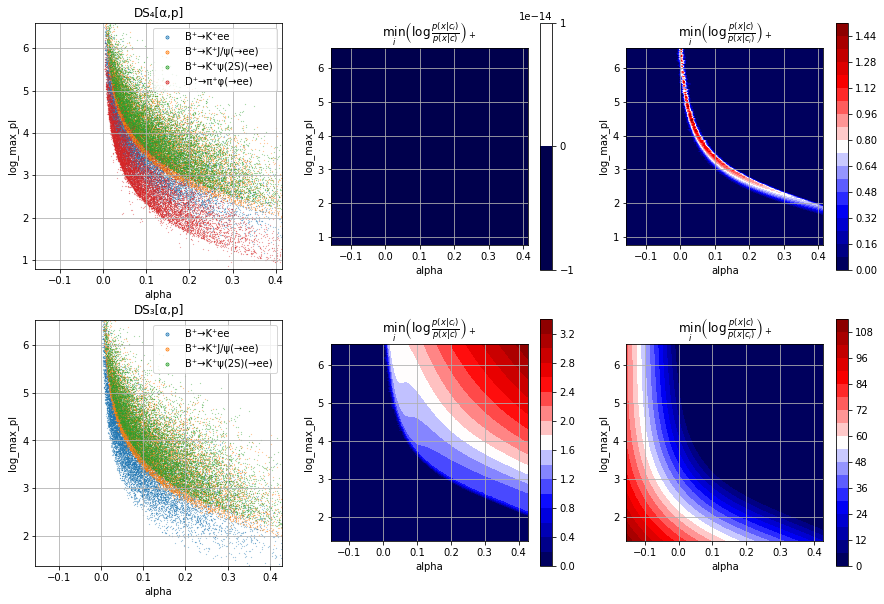

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_ds(ds_la4, scaler=e_la4.scaler, ax=ax[0,0])
plot_clf_min_max(e_la4.model, e_la4.scaler, ax_min=ax[0,1], ax_max=ax[0,2])
plot_ds(ds_la3, scaler=e_la3.scaler, ax=ax[1,0])
plot_clf_min_max(e_la3.model, e_la3.scaler, ax_min=ax[1,1], ax_max=ax[1,2])
plt.show()

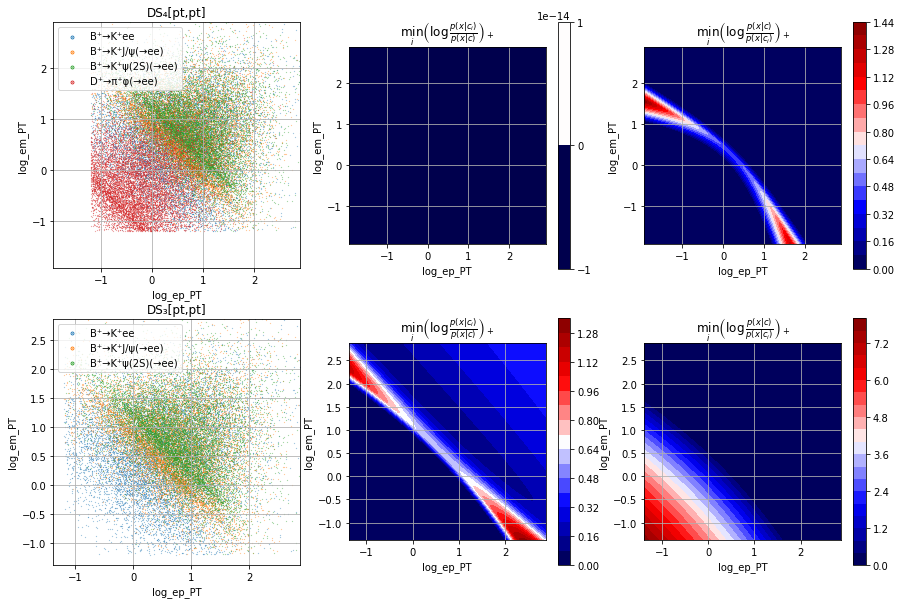

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_ds(ds_pt4, scaler=e_pt4.scaler, ax=ax[0,0])
plot_clf_min_max(e_pt4.model, e_pt4.scaler, ax_min=ax[0,1], ax_max=ax[0,2])
plot_ds(ds_pt3, scaler=e_pt3.scaler, ax=ax[1,0])
plot_clf_min_max(e_pt3.model, e_pt3.scaler, ax_min=ax[1,1], ax_max=ax[1,2])
plt.show()

### Crafting a loss

In [54]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

In [55]:
def compute_lipschitz(model, loader, device=device):
    model.eval()
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        x.requires_grad = True
        model.zero_grad()
        fx = model(x)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x.grad.norm(dim=1)).item())
    return L

In [56]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [57]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [58]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [59]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [60]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    base = model[0]
    linear = model[1]
    opt = torch.optim.SGD(params=base.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                x.requires_grad = True
                clone.zero_grad()
                fx = clone(x)
                L_loss = torch.sum(fx)
                L_loss.backward()
                dx = x.grad
                L = max(L, torch.max(dx.norm(dim=1)).item())
                x.requires_grad = False

                if target_L is not None:
                    ext_dx = dx[None,...] * dx_ # 2*B*n_features
                    ext_x = x[None,...] + ext_dx

                    pred_dfx = model[0](ext_x) # 2*B*N
                    dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                    loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                    total_loss += loss_L
                    loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [61]:
class Weighting:
    def __init__(self, estimator, name=None, n_classes=None, selected_class=0):
        model = clone_model(estimator.model).to(device).eval()
        n_inputs = len(estimator.features)
        with torch.no_grad():
            n_outs = model(torch.zeros(1, n_inputs, dtype=float, device=device)).shape[1]
        n_classes = n_outs if n_classes is None else n_outs
        self.estimator = estimator
        self.n_outs = n_outs
        self.n_classes = n_classes
        self.name = name
        self.selected_class = selected_class
        
        self.model = torch.nn.Sequential(
            torch.nn.Sequential(
                model,
                torch.nn.Softmax(dim=-1),
            ),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device)

    def train(self, dataset, **kwargs):
        data = torch.utils.data.TensorDataset(
            dataset.X(device=device, dtype=float),
            dataset.Y(device=device, dtype=torch.int64)
        )
        loader = Loader(data, batch_size=100000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, self.selected_class, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, self.selected_class, epochs=500, alpha=300, **kwargs)
        return self.model

In [62]:
%%time
w_la4 = Weighting(e_la4, name="w₄[α,p]")
w_la4.train(ds_la4, target_L=0.1)

Epoch 0 loss=-4.000082 W+c=[ 4.7619 -4.4885  2.4164 -1.6218] det=0.006418 L=8.454848
Epoch 1 loss=-4.000081 W+c=[ 4.759  -4.4735  2.3761 -1.622 ] det=0.006472 L=8.483749
Epoch 2 loss=-4.000081 W+c=[ 4.7561 -4.4586  2.337  -1.6221] det=0.006526 L=8.512260
Epoch 3 loss=-4.000081 W+c=[ 4.7532 -4.4439  2.299  -1.6223] det=0.006579 L=8.540379
Epoch 4 loss=-4.000081 W+c=[ 4.7503 -4.4293  2.2621 -1.6224] det=0.006632 L=8.568121
Epoch 5 loss=-4.000081 W+c=[ 4.7475 -4.4149  2.2263 -1.6225] det=0.006684 L=8.595460
Epoch 6 loss=-4.000081 W+c=[ 4.7446 -4.4007  2.1914 -1.6226] det=0.006736 L=8.628172
Epoch 7 loss=-4.000081 W+c=[ 4.7418 -4.3866  2.1575 -1.6228] det=0.006787 L=8.664311
Epoch 8 loss=-4.000082 W+c=[ 4.7389 -4.3727  2.1246 -1.6229] det=0.006838 L=8.700114
Epoch 9 loss=-4.000082 W+c=[ 4.7361 -4.3589  2.0925 -1.623 ] det=0.006888 L=8.735594
Epoch 10 loss=-4.000081 W+c=[ 4.7333 -4.3453  2.0613 -1.6231] det=0.006938 L=8.770749
Epoch 11 loss=-4.000082 W+c=[ 4.7305 -4.3318  2.031  -1.6233] de

Epoch 95 loss=-4.000084 W+c=[ 4.5294 -3.4757  0.9022 -1.6252] det=0.010056 L=11.677246
Epoch 96 loss=-4.000082 W+c=[ 4.5273 -3.4676  0.8965 -1.6251] det=0.010085 L=11.712166
Epoch 97 loss=-4.000084 W+c=[ 4.5252 -3.4595  0.8909 -1.625 ] det=0.010113 L=11.746975
Epoch 98 loss=-4.000083 W+c=[ 4.5231 -3.4515  0.8854 -1.625 ] det=0.010142 L=11.781663
Epoch 99 loss=-4.000083 W+c=[ 4.5211 -3.4435  0.88   -1.6249] det=0.010170 L=11.816237
Epoch 100 loss=-4.000083 W+c=[ 4.519  -3.4355  0.8746 -1.6248] det=0.010198 L=11.850698
Epoch 101 loss=-4.000084 W+c=[ 4.5169 -3.4275  0.8693 -1.6248] det=0.010226 L=11.885047
Epoch 102 loss=-4.000082 W+c=[ 4.5149 -3.4196  0.8641 -1.6247] det=0.010254 L=11.919300
Epoch 103 loss=-4.000083 W+c=[ 4.5128 -3.4117  0.8589 -1.6246] det=0.010282 L=11.953447
Epoch 104 loss=-4.000083 W+c=[ 4.5108 -3.4039  0.8539 -1.6245] det=0.010310 L=11.987481
Epoch 105 loss=-4.000083 W+c=[ 4.5087 -3.3961  0.8488 -1.6245] det=0.010338 L=12.021429
Epoch 106 loss=-4.000084 W+c=[ 4.5067

Epoch 189 loss=-4.000084 W+c=[ 4.3517 -2.8369  0.5833 -1.6148] det=0.012426 L=14.764047
Epoch 190 loss=-4.000084 W+c=[ 4.3499 -2.8312  0.5813 -1.6146] det=0.012449 L=14.795683
Epoch 191 loss=-4.000084 W+c=[ 4.3482 -2.8256  0.5794 -1.6145] det=0.012472 L=14.827306
Epoch 192 loss=-4.000084 W+c=[ 4.3465 -2.8199  0.5774 -1.6144] det=0.012494 L=14.858915
Epoch 193 loss=-4.000084 W+c=[ 4.3448 -2.8143  0.5754 -1.6142] det=0.012517 L=14.890502
Epoch 194 loss=-4.000084 W+c=[ 4.3431 -2.8087  0.5735 -1.6141] det=0.012540 L=14.922093
Epoch 195 loss=-4.000085 W+c=[ 4.3414 -2.8031  0.5716 -1.614 ] det=0.012562 L=14.953651
Epoch 196 loss=-4.000084 W+c=[ 4.3397 -2.7976  0.5697 -1.6138] det=0.012585 L=14.985201
Epoch 197 loss=-4.000083 W+c=[ 4.338  -2.792   0.5678 -1.6137] det=0.012608 L=15.016740
Epoch 198 loss=-4.000084 W+c=[ 4.3363 -2.7865  0.5659 -1.6136] det=0.012630 L=15.048270
Epoch 199 loss=-4.000085 W+c=[ 4.3347 -2.781   0.5641 -1.6134] det=0.012653 L=15.079780
W= [[0.4052 0.1335 0.0691 0.2736

Epoch 94 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 95 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 96 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 97 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 98 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 99 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 100 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 101 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 102 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 103 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 104 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 105 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 106 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 107 loss=-1.000000 W+c=[0

Epoch 204 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 205 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 206 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 207 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 208 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 209 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 210 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 211 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 212 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 213 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 214 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 215 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 216 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 217 loss=-1.000000 

Epoch 314 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 315 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 316 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 317 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 318 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 319 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 320 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 321 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 322 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 323 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 324 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 325 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 326 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 327 loss=-1.000000 

Epoch 424 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 425 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 426 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 427 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 428 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 429 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 430 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 431 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 432 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 433 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 434 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 435 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 436 loss=-1.000000 W+c=[0.   0.25 0.   0.  ] det=0.000000 L=0.000000
Epoch 437 loss=-1.000000 

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=4, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [63]:
%%time
w_la3 = Weighting(e_la3, name="w₃[α,p]")
w_la3.train(ds_la3, target_L=0.1)

Epoch 0 loss=-3.000077 W+c=[ 1.9033 -2.1596  1.2543] det=0.022718 L=7.985671
Epoch 1 loss=-3.000076 W+c=[ 1.9039 -2.1514  1.2483] det=0.022771 L=8.009932
Epoch 2 loss=-3.000077 W+c=[ 1.9044 -2.1433  1.2424] det=0.022823 L=8.034056
Epoch 3 loss=-3.000077 W+c=[ 1.9049 -2.1352  1.2365] det=0.022876 L=8.058033
Epoch 4 loss=-3.000077 W+c=[ 1.9054 -2.1272  1.2307] det=0.022928 L=8.081865
Epoch 5 loss=-3.000078 W+c=[ 1.906  -2.1193  1.2249] det=0.022980 L=8.106847
Epoch 6 loss=-3.000077 W+c=[ 1.9065 -2.1114  1.2192] det=0.023033 L=8.132601
Epoch 7 loss=-3.000077 W+c=[ 1.907  -2.1036  1.2135] det=0.023085 L=8.158211
Epoch 8 loss=-3.000078 W+c=[ 1.9075 -2.0958  1.2079] det=0.023137 L=8.183686
Epoch 9 loss=-3.000078 W+c=[ 1.908  -2.0882  1.2023] det=0.023188 L=8.209016
Epoch 10 loss=-3.000078 W+c=[ 1.9085 -2.0805  1.1967] det=0.023240 L=8.234764
Epoch 11 loss=-3.000080 W+c=[ 1.909  -2.073   1.1913] det=0.023292 L=8.260665
Epoch 12 loss=-3.000080 W+c=[ 1.9095 -2.0655  1.1858] det=0.023343 L=8.286

Epoch 105 loss=-3.000076 W+c=[ 1.9437 -1.5615  0.8268] det=0.027837 L=10.506283
Epoch 106 loss=-3.000074 W+c=[ 1.944  -1.5575  0.8241] det=0.027882 L=10.528751
Epoch 107 loss=-3.000075 W+c=[ 1.9443 -1.5536  0.8213] det=0.027928 L=10.551183
Epoch 108 loss=-3.000073 W+c=[ 1.9445 -1.5498  0.8186] det=0.027974 L=10.573607
Epoch 109 loss=-3.000074 W+c=[ 1.9448 -1.5459  0.816 ] det=0.028019 L=10.596008
Epoch 110 loss=-3.000074 W+c=[ 1.945  -1.5421  0.8133] det=0.028065 L=10.618375
Epoch 111 loss=-3.000074 W+c=[ 1.9453 -1.5383  0.8106] det=0.028110 L=10.640735
Epoch 112 loss=-3.000073 W+c=[ 1.9455 -1.5345  0.808 ] det=0.028156 L=10.663058
Epoch 113 loss=-3.000074 W+c=[ 1.9458 -1.5307  0.8054] det=0.028201 L=10.685372
Epoch 114 loss=-3.000073 W+c=[ 1.9461 -1.527   0.8028] det=0.028247 L=10.707654
Epoch 115 loss=-3.000074 W+c=[ 1.9463 -1.5233  0.8002] det=0.028292 L=10.729923
Epoch 116 loss=-3.000073 W+c=[ 1.9465 -1.5196  0.7976] det=0.028337 L=10.752159
Epoch 117 loss=-3.000073 W+c=[ 1.9468 -1

Epoch 5 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 6 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 7 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 8 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 9 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 10 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 11 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 12 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 13 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 14 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 15 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 16 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 17 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 18 loss=-1.000000 W+c=[0

Epoch 115 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 116 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 117 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 118 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 119 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 120 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 121 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 122 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 123 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 124 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 125 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 126 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 127 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 128 lo

Epoch 223 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 224 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 225 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 226 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 227 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 228 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 229 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 230 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 231 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 232 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 233 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 234 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 235 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 236 lo

Epoch 331 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 332 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 333 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 334 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 335 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 336 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 337 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 338 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 339 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 340 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 341 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 342 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 343 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 344 lo

Epoch 439 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 440 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 441 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 442 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 443 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 444 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 445 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 446 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 447 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 448 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 449 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 450 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 451 loss=-1.000000 W+c=[0.     0.3333 0.    ] det=0.000000 L=0.000000
Epoch 452 lo

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

In [64]:
%%time
w_pt4 = Weighting(e_pt4, name="w₄[pt,pt]")
w_pt4.train(ds_pt4, target_L=0.1)

Epoch 0 loss=-4.000029 W+c=[ 18.3293 -18.7869   5.2246  -3.8465] det=0.000566 L=0.077693
Epoch 1 loss=-4.000027 W+c=[ 18.2221 -18.6651   5.1809  -3.8736] det=0.000571 L=0.077575
Epoch 2 loss=-4.000030 W+c=[ 18.1176 -18.5457   5.1381  -3.9005] det=0.000576 L=0.077461
Epoch 3 loss=-4.000031 W+c=[ 18.0157 -18.4286   5.0959  -3.9274] det=0.000581 L=0.077351
Epoch 4 loss=-4.000029 W+c=[ 17.9163 -18.3138   5.0545  -3.9542] det=0.000586 L=0.077244
Epoch 5 loss=-4.000028 W+c=[ 17.8193 -18.2011   5.0137  -3.9808] det=0.000591 L=0.077142
Epoch 6 loss=-4.000029 W+c=[ 17.7248 -18.0905   4.9736  -4.0073] det=0.000596 L=0.077044
Epoch 7 loss=-4.000030 W+c=[ 17.6326 -17.982    4.9341  -4.0336] det=0.000601 L=0.076949
Epoch 8 loss=-4.000031 W+c=[ 17.5427 -17.8756   4.8953  -4.0598] det=0.000606 L=0.076858
Epoch 9 loss=-4.000030 W+c=[ 17.455  -17.7711   4.8571  -4.0859] det=0.000610 L=0.076770
Epoch 10 loss=-4.000032 W+c=[ 17.3696 -17.6686   4.8195  -4.1118] det=0.000615 L=0.076687
Epoch 11 loss=-4.000

Epoch 92 loss=-4.000036 W+c=[ 14.3563 -13.0604   2.9968  -5.4178] det=0.000932 L=0.077487
Epoch 93 loss=-4.000040 W+c=[ 14.3428 -13.0298   2.9841  -5.4245] det=0.000936 L=0.077547
Epoch 94 loss=-4.000038 W+c=[ 14.3294 -12.9996   2.9716  -5.431 ] det=0.000939 L=0.077608
Epoch 95 loss=-4.000038 W+c=[ 14.3163 -12.9696   2.9592  -5.4373] det=0.000943 L=0.077670
Epoch 96 loss=-4.000038 W+c=[ 14.3033 -12.9399   2.9469  -5.4435] det=0.000946 L=0.077732
Epoch 97 loss=-4.000038 W+c=[ 14.2906 -12.9106   2.9348  -5.4496] det=0.000949 L=0.077795
Epoch 98 loss=-4.000041 W+c=[ 14.278  -12.8816   2.9228  -5.4555] det=0.000953 L=0.077858
Epoch 99 loss=-4.000038 W+c=[ 14.2656 -12.8528   2.911   -5.4612] det=0.000956 L=0.077922
Epoch 100 loss=-4.000040 W+c=[ 14.2534 -12.8244   2.8993  -5.4668] det=0.000960 L=0.077986
Epoch 101 loss=-4.000039 W+c=[ 14.2413 -12.7962   2.8877  -5.4723] det=0.000963 L=0.078051
Epoch 102 loss=-4.000039 W+c=[ 14.2294 -12.7683   2.8762  -5.4776] det=0.000966 L=0.078116
Epoch 1

Epoch 183 loss=-4.000043 W+c=[ 13.5192 -11.1235   2.2488  -5.6209] det=0.001235 L=0.084347
Epoch 184 loss=-4.000043 W+c=[ 13.5116 -11.1082   2.2437  -5.6206] det=0.001239 L=0.084431
Epoch 185 loss=-4.000042 W+c=[ 13.504  -11.093    2.2386  -5.6202] det=0.001242 L=0.084515
Epoch 186 loss=-4.000044 W+c=[ 13.4965 -11.0779   2.2335  -5.6198] det=0.001245 L=0.084600
Epoch 187 loss=-4.000042 W+c=[ 13.4889 -11.0628   2.2285  -5.6193] det=0.001249 L=0.084684
Epoch 188 loss=-4.000044 W+c=[ 13.4814 -11.0479   2.2235  -5.6189] det=0.001252 L=0.084768
Epoch 189 loss=-4.000041 W+c=[ 13.4738 -11.033    2.2186  -5.6184] det=0.001255 L=0.084853
Epoch 190 loss=-4.000042 W+c=[ 13.4663 -11.0182   2.2137  -5.6179] det=0.001258 L=0.084938
Epoch 191 loss=-4.000042 W+c=[ 13.4588 -11.0034   2.2089  -5.6173] det=0.001262 L=0.085023
Epoch 192 loss=-4.000044 W+c=[ 13.4512 -10.9888   2.204   -5.6167] det=0.001265 L=0.085108
Epoch 193 loss=-4.000043 W+c=[ 13.4437 -10.9742   2.1993  -5.6161] det=0.001268 L=0.085193

Epoch 73 loss=-12.933883 W+c=[20.3282 -4.6587  2.5808 -3.7977] det=0.001452 L=0.184083
Epoch 74 loss=-12.941917 W+c=[20.3063 -4.6325  2.5906 -3.7869] det=0.001456 L=0.185590
Epoch 75 loss=-12.949818 W+c=[20.2844 -4.6065  2.6001 -3.7763] det=0.001460 L=0.187103
Epoch 76 loss=-12.957557 W+c=[20.2626 -4.5809  2.6093 -3.7658] det=0.001465 L=0.188622
Epoch 77 loss=-12.965147 W+c=[20.2408 -4.5557  2.6182 -3.7554] det=0.001469 L=0.190147
Epoch 78 loss=-12.972569 W+c=[20.2192 -4.5307  2.6268 -3.7451] det=0.001473 L=0.191679
Epoch 79 loss=-12.979808 W+c=[20.1976 -4.5061  2.6351 -3.735 ] det=0.001477 L=0.193216
Epoch 80 loss=-12.986863 W+c=[20.1761 -4.4818  2.6431 -3.725 ] det=0.001481 L=0.194759
Epoch 81 loss=-12.993718 W+c=[20.1547 -4.4578  2.6507 -3.715 ] det=0.001486 L=0.196308
Epoch 82 loss=-13.000374 W+c=[20.1335 -4.4342  2.6581 -3.7052] det=0.001490 L=0.197864
Epoch 83 loss=-13.006832 W+c=[20.1125 -4.4108  2.6652 -3.6956] det=0.001494 L=0.199426
Epoch 84 loss=-13.013071 W+c=[20.0916 -4.38

Epoch 167 loss=-12.406693 W+c=[19.6558 -3.105   2.4196 -3.2386] det=0.001839 L=0.343440
Epoch 168 loss=-12.383523 W+c=[19.6728 -3.0946  2.41   -3.237 ] det=0.001843 L=0.345207
Epoch 169 loss=-12.359984 W+c=[19.6904 -3.0843  2.4003 -3.2354] det=0.001846 L=0.346969
Epoch 170 loss=-12.336081 W+c=[19.7087 -3.074   2.3905 -3.2339] det=0.001849 L=0.348726
Epoch 171 loss=-12.311816 W+c=[19.7276 -3.0638  2.3807 -3.2325] det=0.001852 L=0.350478
Epoch 172 loss=-12.287221 W+c=[19.7472 -3.0538  2.3708 -3.2312] det=0.001855 L=0.352223
Epoch 173 loss=-12.262269 W+c=[19.7675 -3.0437  2.3608 -3.23  ] det=0.001858 L=0.353962
Epoch 174 loss=-12.236976 W+c=[19.7884 -3.0338  2.3507 -3.2288] det=0.001860 L=0.355693
Epoch 175 loss=-12.211349 W+c=[19.81   -3.0239  2.3406 -3.2278] det=0.001863 L=0.357418
Epoch 176 loss=-12.185381 W+c=[19.8323 -3.0142  2.3304 -3.2268] det=0.001866 L=0.359134
Epoch 177 loss=-12.159092 W+c=[19.8552 -3.0045  2.3201 -3.2259] det=0.001869 L=0.360843
Epoch 178 loss=-12.132493 W+c=[1

Epoch 261 loss=-9.635264 W+c=[23.1684 -2.4722  1.4908 -3.3187] det=0.001981 L=0.471058
Epoch 262 loss=-9.610057 W+c=[23.2083 -2.4691  1.4833 -3.3198] det=0.001982 L=0.471864
Epoch 263 loss=-9.585106 W+c=[23.2478 -2.4661  1.4758 -3.321 ] det=0.001983 L=0.472655
Epoch 264 loss=-9.560375 W+c=[23.287  -2.4632  1.4684 -3.322 ] det=0.001984 L=0.473432
Epoch 265 loss=-9.535876 W+c=[23.3258 -2.4603  1.4611 -3.3231] det=0.001985 L=0.474259
Epoch 266 loss=-9.511617 W+c=[23.3642 -2.4575  1.4539 -3.3241] det=0.001987 L=0.475131
Epoch 267 loss=-9.487604 W+c=[23.4022 -2.4547  1.4467 -3.3251] det=0.001988 L=0.475987
Epoch 268 loss=-9.463823 W+c=[23.4398 -2.452   1.4396 -3.326 ] det=0.001989 L=0.476830
Epoch 269 loss=-9.440269 W+c=[23.477  -2.4494  1.4326 -3.3269] det=0.001990 L=0.477658
Epoch 270 loss=-9.416940 W+c=[23.5138 -2.4468  1.4256 -3.3277] det=0.001992 L=0.478473
Epoch 271 loss=-9.393855 W+c=[23.5501 -2.4443  1.4187 -3.3285] det=0.001993 L=0.479274
Epoch 272 loss=-9.370988 W+c=[23.5861 -2.44

Epoch 356 loss=-8.016313 W+c=[25.4127 -2.3542  1.0407 -3.2842] det=0.002148 L=0.523777
Epoch 357 loss=-8.004148 W+c=[25.426  -2.3539  1.0379 -3.2831] det=0.002150 L=0.524171
Epoch 358 loss=-7.992030 W+c=[25.4393 -2.3535  1.0352 -3.2819] det=0.002152 L=0.524563
Epoch 359 loss=-7.979953 W+c=[25.4525 -2.3532  1.0325 -3.2807] det=0.002154 L=0.524953
Epoch 360 loss=-7.967911 W+c=[25.4656 -2.3528  1.0299 -3.2795] det=0.002156 L=0.525343
Epoch 361 loss=-7.955948 W+c=[25.4786 -2.3525  1.0272 -3.2783] det=0.002158 L=0.525731
Epoch 362 loss=-7.944010 W+c=[25.4916 -2.3522  1.0246 -3.2772] det=0.002160 L=0.526117
Epoch 363 loss=-7.932116 W+c=[25.5044 -2.3518  1.022  -3.276 ] det=0.002162 L=0.526501
Epoch 364 loss=-7.920283 W+c=[25.5173 -2.3515  1.0194 -3.2748] det=0.002163 L=0.526883
Epoch 365 loss=-7.908490 W+c=[25.53   -2.3512  1.0169 -3.2736] det=0.002165 L=0.527264
Epoch 366 loss=-7.896745 W+c=[25.5427 -2.3509  1.0144 -3.2724] det=0.002167 L=0.527644
Epoch 367 loss=-7.885025 W+c=[25.5552 -2.35

Epoch 451 loss=-7.090524 W+c=[26.4233 -2.3266  0.8849 -3.1673] det=0.002282 L=0.555834
Epoch 452 loss=-7.081802 W+c=[26.4326 -2.3264  0.8838 -3.1663] det=0.002283 L=0.556113
Epoch 453 loss=-7.073099 W+c=[26.4419 -2.3262  0.8827 -3.1653] det=0.002284 L=0.556391
Epoch 454 loss=-7.064461 W+c=[26.4511 -2.3259  0.8815 -3.1643] det=0.002285 L=0.556666
Epoch 455 loss=-7.055855 W+c=[26.4603 -2.3257  0.8804 -3.1633] det=0.002286 L=0.556941
Epoch 456 loss=-7.047279 W+c=[26.4695 -2.3255  0.8793 -3.1624] det=0.002287 L=0.557215
Epoch 457 loss=-7.038756 W+c=[26.4786 -2.3253  0.8782 -3.1614] det=0.002288 L=0.557487
Epoch 458 loss=-7.030285 W+c=[26.4876 -2.325   0.8771 -3.1604] det=0.002289 L=0.557757
Epoch 459 loss=-7.021835 W+c=[26.4967 -2.3248  0.876  -3.1595] det=0.002291 L=0.558027
Epoch 460 loss=-7.013425 W+c=[26.5057 -2.3246  0.8749 -3.1585] det=0.002292 L=0.558296
Epoch 461 loss=-7.005058 W+c=[26.5146 -2.3244  0.8738 -3.1575] det=0.002293 L=0.558564
Epoch 462 loss=-6.996761 W+c=[26.5235 -2.32

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=4, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [65]:
%%time
w_pt3 = Weighting(e_pt3, name="w₃[pt,pt]")
w_pt3.train(ds_pt3, target_L=0.1)

Epoch 0 loss=-3.000050 W+c=[ 5.1607 -5.5986  1.4283] det=0.005471 L=0.069256
Epoch 1 loss=-3.000051 W+c=[ 5.1613 -5.574   1.4104] det=0.005515 L=0.069341
Epoch 2 loss=-3.000051 W+c=[ 5.1618 -5.5501  1.3931] det=0.005558 L=0.069425
Epoch 3 loss=-3.000051 W+c=[ 5.1624 -5.527   1.3763] det=0.005601 L=0.069509
Epoch 4 loss=-3.000051 W+c=[ 5.1629 -5.5045  1.3601] det=0.005644 L=0.069591
Epoch 5 loss=-3.000050 W+c=[ 5.1633 -5.4826  1.3443] det=0.005686 L=0.069673
Epoch 6 loss=-3.000053 W+c=[ 5.1637 -5.4614  1.329 ] det=0.005727 L=0.069755
Epoch 7 loss=-3.000053 W+c=[ 5.1641 -5.4408  1.3142] det=0.005768 L=0.069835
Epoch 8 loss=-3.000052 W+c=[ 5.1644 -5.4208  1.2999] det=0.005808 L=0.069916
Epoch 9 loss=-3.000053 W+c=[ 5.1647 -5.4013  1.2859] det=0.005848 L=0.069996
Epoch 10 loss=-3.000052 W+c=[ 5.1649 -5.3823  1.2724] det=0.005887 L=0.070075
Epoch 11 loss=-3.000051 W+c=[ 5.1651 -5.3638  1.2592] det=0.005926 L=0.070154
Epoch 12 loss=-3.000052 W+c=[ 5.1652 -5.3458  1.2465] det=0.005964 L=0.070

Epoch 106 loss=-3.000060 W+c=[ 5.0523 -4.5622  0.77  ] det=0.008623 L=0.078211
Epoch 107 loss=-3.000061 W+c=[ 5.0505 -4.5578  0.7681] det=0.008646 L=0.078306
Epoch 108 loss=-3.000062 W+c=[ 5.0487 -4.5534  0.7661] det=0.008670 L=0.078402
Epoch 109 loss=-3.000062 W+c=[ 5.0468 -4.549   0.7643] det=0.008693 L=0.078497
Epoch 110 loss=-3.000062 W+c=[ 5.045  -4.5447  0.7624] det=0.008716 L=0.078593
Epoch 111 loss=-3.000062 W+c=[ 5.0432 -4.5405  0.7605] det=0.008739 L=0.078689
Epoch 112 loss=-3.000062 W+c=[ 5.0414 -4.5362  0.7587] det=0.008763 L=0.078785
Epoch 113 loss=-3.000061 W+c=[ 5.0396 -4.532   0.7569] det=0.008786 L=0.078881
Epoch 114 loss=-3.000061 W+c=[ 5.0377 -4.5278  0.7551] det=0.008809 L=0.078977
Epoch 115 loss=-3.000063 W+c=[ 5.0359 -4.5236  0.7534] det=0.008832 L=0.079074
Epoch 116 loss=-3.000061 W+c=[ 5.0341 -4.5195  0.7516] det=0.008855 L=0.079171
Epoch 117 loss=-3.000061 W+c=[ 5.0323 -4.5153  0.7499] det=0.008878 L=0.079268
Epoch 118 loss=-3.000062 W+c=[ 5.0304 -4.5112  0.748

Epoch 8 loss=-17.062786 W+c=[ 5.8874 -2.7175  0.5211] det=0.011068 L=0.121566
Epoch 9 loss=-15.501389 W+c=[ 6.4641 -2.5257  0.3652] det=0.010588 L=0.124424
Epoch 10 loss=-14.485695 W+c=[ 6.9264 -2.4057  0.2629] det=0.010194 L=0.126906
Epoch 11 loss=-13.805396 W+c=[ 7.2802 -2.3224  0.1964] det=0.009899 L=0.129345
Epoch 12 loss=-13.335668 W+c=[ 7.5433 -2.259   0.1542] det=0.009690 L=0.131817
Epoch 13 loss=-13.000987 W+c=[ 7.7357 -2.2072  0.1287] det=0.009545 L=0.134358
Epoch 14 loss=-12.754614 W+c=[ 7.8752 -2.1626  0.1146] det=0.009446 L=0.136968
Epoch 15 loss=-12.566913 W+c=[ 7.9764 -2.1227  0.1083] det=0.009380 L=0.139648
Epoch 16 loss=-12.418803 W+c=[ 8.0501 -2.0862  0.1072] det=0.009337 L=0.142401
Epoch 17 loss=-12.297681 W+c=[ 8.1043 -2.0522  0.1097] det=0.009309 L=0.145185
Epoch 18 loss=-12.195183 W+c=[ 8.1448 -2.0202  0.1145] det=0.009292 L=0.148021
Epoch 19 loss=-12.105720 W+c=[ 8.1756 -1.9897  0.1209] det=0.009283 L=0.150887
Epoch 20 loss=-12.025432 W+c=[ 8.1997 -1.9606  0.1282]

Epoch 113 loss=-7.540474 W+c=[10.5461 -0.9445  0.3441] det=0.008000 L=0.463568
Epoch 114 loss=-7.504222 W+c=[10.5897 -0.9407  0.3424] det=0.007978 L=0.466835
Epoch 115 loss=-7.468337 W+c=[10.6336 -0.937   0.3407] det=0.007956 L=0.470082
Epoch 116 loss=-7.432821 W+c=[10.6777 -0.9333  0.3389] det=0.007934 L=0.473302
Epoch 117 loss=-7.397678 W+c=[10.7221 -0.9297  0.3371] det=0.007912 L=0.476496
Epoch 118 loss=-7.362899 W+c=[10.7666 -0.9261  0.3353] det=0.007890 L=0.479723
Epoch 119 loss=-7.328485 W+c=[10.8114 -0.9226  0.3335] det=0.007868 L=0.482921
Epoch 120 loss=-7.294433 W+c=[10.8565 -0.9191  0.3317] det=0.007846 L=0.486090
Epoch 121 loss=-7.260747 W+c=[10.9017 -0.9157  0.3298] det=0.007825 L=0.489235
Epoch 122 loss=-7.227423 W+c=[10.9471 -0.9124  0.3279] det=0.007803 L=0.492405
Epoch 123 loss=-7.194482 W+c=[10.9927 -0.9091  0.326 ] det=0.007782 L=0.495546
Epoch 124 loss=-7.161901 W+c=[11.0385 -0.9059  0.3241] det=0.007761 L=0.498719
Epoch 125 loss=-7.129682 W+c=[11.0844 -0.9027  0.322

Epoch 217 loss=-5.369467 W+c=[15.3002 -0.749   0.1575] det=0.006485 L=0.735483
Epoch 218 loss=-5.359200 W+c=[15.3413 -0.7482  0.1562] det=0.006478 L=0.737477
Epoch 219 loss=-5.349045 W+c=[15.3824 -0.7475  0.1548] det=0.006471 L=0.739454
Epoch 220 loss=-5.339015 W+c=[15.4233 -0.7467  0.1535] det=0.006464 L=0.741435
Epoch 221 loss=-5.329086 W+c=[15.4641 -0.7459  0.1522] det=0.006457 L=0.743415
Epoch 222 loss=-5.319284 W+c=[15.5047 -0.7452  0.1509] det=0.006450 L=0.745377
Epoch 223 loss=-5.309572 W+c=[15.5452 -0.7444  0.1495] det=0.006444 L=0.747322
Epoch 224 loss=-5.299978 W+c=[15.5856 -0.7437  0.1483] det=0.006437 L=0.749250
Epoch 225 loss=-5.290497 W+c=[15.6258 -0.743   0.147 ] det=0.006430 L=0.751161
Epoch 226 loss=-5.281122 W+c=[15.6659 -0.7422  0.1457] det=0.006424 L=0.753054
Epoch 227 loss=-5.271854 W+c=[15.7058 -0.7415  0.1444] det=0.006417 L=0.754930
Epoch 228 loss=-5.262673 W+c=[15.7455 -0.7408  0.1432] det=0.006411 L=0.756790
Epoch 229 loss=-5.253604 W+c=[15.7852 -0.7401  0.141

Epoch 321 loss=-4.716210 W+c=[18.8552 -0.7025  0.0629] det=0.006081 L=0.899185
Epoch 322 loss=-4.712565 W+c=[18.8828 -0.7023  0.0624] det=0.006079 L=0.900426
Epoch 323 loss=-4.708955 W+c=[18.9103 -0.7021  0.0618] det=0.006077 L=0.901660
Epoch 324 loss=-4.705375 W+c=[18.9377 -0.7018  0.0613] det=0.006076 L=0.902885
Epoch 325 loss=-4.701825 W+c=[18.9649 -0.7016  0.0608] det=0.006074 L=0.904104
Epoch 326 loss=-4.698302 W+c=[18.992  -0.7014  0.0602] det=0.006072 L=0.905314
Epoch 327 loss=-4.694823 W+c=[19.019  -0.7012  0.0597] det=0.006071 L=0.906515
Epoch 328 loss=-4.691356 W+c=[19.046  -0.701   0.0592] det=0.006069 L=0.907712
Epoch 329 loss=-4.687933 W+c=[19.0728 -0.7008  0.0587] det=0.006067 L=0.908898
Epoch 330 loss=-4.684546 W+c=[19.0995 -0.7006  0.0582] det=0.006066 L=0.910077
Epoch 331 loss=-4.681172 W+c=[19.1261 -0.7004  0.0576] det=0.006064 L=0.911249
Epoch 332 loss=-4.677835 W+c=[19.1526 -0.7002  0.0571] det=0.006063 L=0.912414
Epoch 333 loss=-4.674528 W+c=[19.179  -0.7     0.056

Epoch 425 loss=-4.618250 W+c=[19.5507 -0.6813  0.0513] det=0.006474 L=0.918932
Epoch 426 loss=-4.617855 W+c=[19.5523 -0.6811  0.0513] det=0.006479 L=0.918928
Epoch 427 loss=-4.617476 W+c=[19.5538 -0.6809  0.0513] det=0.006483 L=0.918922
Epoch 428 loss=-4.617089 W+c=[19.5554 -0.6807  0.0514] det=0.006487 L=0.918918
Epoch 429 loss=-4.616709 W+c=[19.5569 -0.6805  0.0514] det=0.006492 L=0.918913
Epoch 430 loss=-4.616334 W+c=[19.5585 -0.6803  0.0514] det=0.006496 L=0.918907
Epoch 431 loss=-4.615954 W+c=[19.5601 -0.6801  0.0514] det=0.006501 L=0.918902
Epoch 432 loss=-4.615576 W+c=[19.5616 -0.6799  0.0514] det=0.006505 L=0.918897
Epoch 433 loss=-4.615197 W+c=[19.5631 -0.6797  0.0514] det=0.006509 L=0.918891
Epoch 434 loss=-4.614820 W+c=[19.5646 -0.6795  0.0514] det=0.006514 L=0.918887
Epoch 435 loss=-4.614459 W+c=[19.5662 -0.6793  0.0515] det=0.006518 L=0.918879
Epoch 436 loss=-4.614084 W+c=[19.5677 -0.6791  0.0515] det=0.006522 L=0.918875
Epoch 437 loss=-4.613717 W+c=[19.5691 -0.6789  0.051

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

In [66]:
%%time
w_a4 = Weighting(e_a4, name="w₄[α]")
w_a4.train(ds_a4, target_L=0.1)

Epoch 0 loss=-3.999931 W+c=[ 2200.6006  2915.7524 -1971.5812 -3136.3906] det=0.000000 L=0.423189
Epoch 1 loss=-4.000778 W+c=[ 2143.3813  2709.167  -1783.5376 -3034.77  ] det=0.000000 L=0.423748
Epoch 2 loss=-3.999996 W+c=[ 2093.5493  2540.826  -1631.9586 -2948.0117] det=0.000000 L=0.424061
Epoch 3 loss=-3.999920 W+c=[ 2054.54    2413.0881 -1515.4088 -2881.2832] det=0.000000 L=0.424610
Epoch 4 loss=-4.000305 W+c=[ 2019.7765  2306.4883 -1418.35   -2823.1572] det=0.000000 L=0.425235
Epoch 5 loss=-4.000378 W+c=[ 1988.6765  2215.5935 -1335.7314 -2772.0105] det=0.000000 L=0.425984
Epoch 6 loss=-4.000290 W+c=[ 1960.9666  2138.5098 -1265.3901 -2727.2986] det=0.000000 L=0.426576
Epoch 7 loss=-4.000111 W+c=[ 1935.583   2071.5166 -1204.1743 -2687.1   ] det=0.000000 L=0.427227
Epoch 8 loss=-4.000397 W+c=[ 1912.1553  2013.1415 -1150.6444 -2650.7466] det=0.000000 L=0.428075
Epoch 9 loss=-4.000385 W+c=[ 1890.7097  1962.2029 -1103.5981 -2618.08  ] det=0.000000 L=0.428649
Epoch 10 loss=-3.999767 W+c=[ 

Epoch 84 loss=-4.000217 W+c=[ 1129.6475  1256.0834  -396.2159 -1715.7283] det=0.000000 L=0.491431
Epoch 85 loss=-3.999569 W+c=[ 1122.6289  1253.2446  -393.5103 -1708.1396] det=0.000000 L=0.492131
Epoch 86 loss=-4.000006 W+c=[ 1116.1107  1251.4447  -391.2419 -1701.4318] det=0.000000 L=0.492996
Epoch 87 loss=-3.999850 W+c=[ 1109.4558  1249.2869  -388.8618 -1694.4426] det=0.000000 L=0.493739
Epoch 88 loss=-3.999968 W+c=[ 1102.9108  1247.29    -386.5714 -1687.615 ] det=0.000000 L=0.494546
Epoch 89 loss=-4.000158 W+c=[ 1096.5471  1245.5687  -384.4091 -1681.0706] det=0.000000 L=0.495348
Epoch 90 loss=-4.000037 W+c=[ 1089.9541  1243.2153  -382.0258 -1674.0536] det=0.000000 L=0.496068
Epoch 91 loss=-4.000075 W+c=[ 1083.5579  1241.403   -379.8929 -1667.4092] det=0.000000 L=0.496830
Epoch 92 loss=-3.999732 W+c=[ 1077.0875  1239.1827  -377.6152 -1660.545 ] det=0.000000 L=0.497545
Epoch 93 loss=-3.999996 W+c=[ 1070.835   1237.4402  -375.5472 -1654.069 ] det=0.000000 L=0.498244
Epoch 94 loss=-4.000

Epoch 167 loss=-3.999937 W+c=[  707.9497  1117.9739  -270.4957 -1262.4529] det=0.000000 L=0.549083
Epoch 168 loss=-4.000146 W+c=[  704.2573  1116.4348  -269.5025 -1258.2551] det=0.000000 L=0.549817
Epoch 169 loss=-3.999983 W+c=[  700.5822  1115.0159  -268.5684 -1254.1008] det=0.000000 L=0.550446
Epoch 170 loss=-4.000136 W+c=[  696.9271  1113.6024  -267.645  -1249.9628] det=0.000000 L=0.551184
Epoch 171 loss=-3.999960 W+c=[  693.2685  1111.9633  -266.6458 -1245.7458] det=0.000000 L=0.551831
Epoch 172 loss=-4.000182 W+c=[  689.7173  1110.6638  -265.7679 -1241.7571] det=0.000000 L=0.552567
Epoch 173 loss=-4.000060 W+c=[  686.1543  1109.2025  -264.842  -1237.6951] det=0.000000 L=0.553198
Epoch 174 loss=-3.999977 W+c=[  682.6089  1107.6884  -263.904  -1233.6305] det=0.000000 L=0.553857
Epoch 175 loss=-4.000059 W+c=[  679.0811  1106.2162  -262.9917 -1229.5894] det=0.000000 L=0.554586
Epoch 176 loss=-4.000100 W+c=[  675.5669  1104.6731  -262.0604 -1225.5356] det=0.000000 L=0.555247
Epoch 177 

Epoch 47 loss=-3.273475 W+c=[ 1908.6646   127.5652   -78.2716 -1321.2664] det=0.000000 L=0.109341
Epoch 48 loss=-3.288162 W+c=[ 1904.0806   129.5392   -78.1435 -1318.8477] det=0.000000 L=0.109025
Epoch 49 loss=-3.302130 W+c=[ 1899.7034   131.4868   -78.0032 -1316.5709] det=0.000000 L=0.108741
Epoch 50 loss=-3.315458 W+c=[ 1895.1748   133.5789   -77.9162 -1314.2279] det=0.000000 L=0.108450
Epoch 51 loss=-3.329291 W+c=[ 1891.1289   135.8429   -77.8956 -1312.259 ] det=0.000000 L=0.108143
Epoch 52 loss=-3.341729 W+c=[ 1886.3069   137.6882   -77.6995 -1309.6781] det=0.000000 L=0.107873
Epoch 53 loss=-3.353885 W+c=[ 1881.8693   139.7676   -77.5991 -1307.4128] det=0.000000 L=0.107602
Epoch 54 loss=-3.366130 W+c=[ 1877.546    142.0385   -77.5703 -1305.2732] det=0.000000 L=0.107321
Epoch 55 loss=-3.377843 W+c=[ 1873.3339   144.2938   -77.5327 -1303.2133] det=0.000000 L=0.107061
Epoch 56 loss=2.478364 W+c=[ 1868.721    146.2843   -77.3844 -1300.8289] det=0.000000 L=0.287043
Epoch 57 loss=-3.4237

Epoch 131 loss=-3.842381 W+c=[ 1771.4       71.451    -54.7467 -1127.6702] det=0.000000 L=0.094454
Epoch 132 loss=-3.844589 W+c=[ 1764.5696    77.2863   -55.1225 -1126.1079] det=0.000000 L=0.094357
Epoch 133 loss=-3.846738 W+c=[ 1758.0327    83.1633   -55.5288 -1124.7231] det=0.000000 L=0.094254
Epoch 134 loss=-3.848872 W+c=[ 1750.9946    88.6283   -55.7953 -1122.92  ] det=0.000000 L=0.094145
Epoch 135 loss=-3.850692 W+c=[ 1744.1481    94.0853   -56.071  -1121.2224] det=0.000000 L=0.094058
Epoch 136 loss=0.389776 W+c=[ 1737.5842    99.5296   -56.3582 -1119.6847] det=0.000000 L=0.276336
Epoch 137 loss=-3.856118 W+c=[ 1768.6388    61.6176   -53.6015 -1114.8698] det=0.000000 L=0.093958
Epoch 138 loss=-3.858320 W+c=[ 1761.9886    67.6019   -53.9561 -1113.5508] det=0.000000 L=0.093858
Epoch 139 loss=-3.860216 W+c=[ 1755.0809    73.5297   -54.3008 -1112.0415] det=0.000000 L=0.093755
Epoch 140 loss=-3.862063 W+c=[ 1747.8538    79.2735   -54.59   -1110.2777] det=0.000000 L=0.093648
Epoch 141 l

Epoch 215 loss=-3.952771 W+c=[1631.9248   77.1213  -52.8773 -979.7267] det=0.000000 L=0.089671
Epoch 216 loss=-3.954011 W+c=[1624.3384   83.9966  -53.0951 -978.5409] det=0.000000 L=0.089597
Epoch 217 loss=-3.955371 W+c=[1617.1765   91.0319  -53.3932 -977.6166] det=0.000000 L=0.089519
Epoch 218 loss=-0.091367 W+c=[1609.5718   97.7109  -53.5838 -976.3409] det=0.000000 L=0.275434
Epoch 219 loss=-3.953322 W+c=[1642.1228   58.8145  -52.3163 -972.3184] det=0.000000 L=0.089657
Epoch 220 loss=-3.954723 W+c=[1634.5913   66.2512  -52.636  -971.3669] det=0.000000 L=0.089585
Epoch 221 loss=-3.956110 W+c=[1627.0525   73.2355  -52.8221 -970.3056] det=0.000000 L=0.089507
Epoch 222 loss=-3.957433 W+c=[1619.6266   80.5141  -53.1303 -969.3447] det=0.000000 L=0.089437
Epoch 223 loss=-3.958575 W+c=[1611.9062   87.4721  -53.3482 -968.1274] det=0.000000 L=0.089372
Epoch 224 loss=-0.151086 W+c=[1604.6067   94.4987  -53.6133 -967.1516] det=0.000000 L=0.274891
Epoch 225 loss=-3.956314 W+c=[1636.741    55.7724 

Epoch 302 loss=-3.987721 W+c=[1501.9121  107.3992  -56.4916 -864.0553] det=0.000000 L=0.087976
Epoch 303 loss=-0.120480 W+c=[1493.9784  115.0009  -56.603  -863.1835] det=0.000000 L=0.278240
Epoch 304 loss=-3.981731 W+c=[1530.9855   72.1     -56.3952 -859.78  ] det=0.000000 L=0.088279
Epoch 305 loss=-3.983340 W+c=[1523.034    80.2458  -56.5276 -859.1405] det=0.000000 L=0.088204
Epoch 306 loss=-3.984779 W+c=[1514.9513   88.114   -56.5945 -858.3541] det=0.000000 L=0.088125
Epoch 307 loss=-3.986278 W+c=[1506.7592   95.8311  -56.6418 -857.4524] det=0.000000 L=0.088058
Epoch 308 loss=-3.987827 W+c=[1499.1165  103.6818  -56.7652 -856.8578] det=0.000000 L=0.087982
Epoch 309 loss=-0.176622 W+c=[1491.2753  111.377   -56.8625 -856.1001] det=0.000000 L=0.277631
Epoch 310 loss=-3.981727 W+c=[1527.8782   68.8185  -56.7279 -852.6998] det=0.000000 L=0.088273
Epoch 311 loss=-3.983288 W+c=[1519.7268   76.9616  -56.8122 -851.9906] det=0.000000 L=0.088198
Epoch 312 loss=-3.984966 W+c=[1511.6626   85.0683 

Epoch 389 loss=-0.096845 W+c=[1403.2468  130.0612  -60.873  -774.8013] det=0.000000 L=0.280574
Epoch 390 loss=-3.983399 W+c=[1445.281    82.8148  -61.5103 -772.1458] det=0.000000 L=0.088307
Epoch 391 loss=-3.985467 W+c=[1436.5527   91.6083  -61.4588 -771.5501] det=0.000000 L=0.088225
Epoch 392 loss=-3.987481 W+c=[1428.0083  100.1549  -61.3698 -770.9804] det=0.000000 L=0.088134
Epoch 393 loss=-3.989607 W+c=[1419.5734  108.7692  -61.3373 -770.4511] det=0.000000 L=0.088047
Epoch 394 loss=-3.991607 W+c=[1411.0244  117.1164  -61.2562 -769.7867] det=0.000000 L=0.087971
Epoch 395 loss=-3.993458 W+c=[1402.678   125.5048  -61.2252 -769.2075] det=0.000000 L=0.087891
Epoch 396 loss=-0.060611 W+c=[1394.3369  133.6832  -61.1614 -768.5679] det=0.000000 L=0.281199
Epoch 397 loss=-3.983333 W+c=[1437.321    85.7919  -61.8985 -766.0594] det=0.000000 L=0.088322
Epoch 398 loss=-3.985456 W+c=[1428.4685   94.4428  -61.7816 -765.3934] det=0.000000 L=0.088240
Epoch 399 loss=-3.987650 W+c=[1420.0366  103.1987 

Epoch 476 loss=-3.985165 W+c=[1341.1007  132.6125  -65.1557 -705.1359] det=0.000000 L=0.088460
Epoch 477 loss=-3.987679 W+c=[1332.1827  141.3142  -64.9409 -704.5637] det=0.000000 L=0.088356
Epoch 478 loss=0.013005 W+c=[1323.4089  150.0742  -64.7882 -704.0411] det=0.000000 L=0.283402
Epoch 479 loss=-3.973080 W+c=[1372.272    97.1846  -66.2106 -702.335 ] det=0.000000 L=0.088907
Epoch 480 loss=-3.975965 W+c=[1362.9585  106.5206  -65.9882 -701.8201] det=0.000000 L=0.088803
Epoch 481 loss=-3.978897 W+c=[1353.8159  115.8133  -65.8007 -701.3492] det=0.000000 L=0.088701
Epoch 482 loss=-3.981610 W+c=[1344.6162  124.9138  -65.5983 -700.7838] det=0.000000 L=0.088602
Epoch 483 loss=-3.984217 W+c=[1335.5471  133.9745  -65.4283 -700.2441] det=0.000000 L=0.088506
Epoch 484 loss=-3.986924 W+c=[1326.7424  142.8998  -65.2611 -699.7848] det=0.000000 L=0.088415
Epoch 485 loss=0.021644 W+c=[1317.7618  151.5211  -65.0433 -699.153 ] det=0.000000 L=0.283594
Epoch 486 loss=-3.972084 W+c=[1367.3738   98.1434  -

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=1, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=4, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=4, out_features=1, bias=False)
)

In [67]:
%%time
w_a3 = Weighting(e_a3, name="w₃[α]")
w_a3.train(ds_a3, target_L=0.1)

Epoch 0 loss=-3.000065 W+c=[ 154.6894 -740.4022  589.5969] det=0.000007 L=0.278153
Epoch 1 loss=-2.999958 W+c=[ 154.0726 -733.5606  583.8074] det=0.000007 L=0.278260
Epoch 2 loss=-3.000277 W+c=[ 153.4935 -727.0439  578.2921] det=0.000007 L=0.278334
Epoch 3 loss=-2.999892 W+c=[ 152.8855 -720.492   572.7562] det=0.000007 L=0.278344
Epoch 4 loss=-2.999909 W+c=[ 152.2802 -714.0689  567.3326] det=0.000007 L=0.278428
Epoch 5 loss=-3.000044 W+c=[ 151.7239 -708.0167  562.2203] det=0.000007 L=0.278515
Epoch 6 loss=-2.999832 W+c=[ 151.1279 -701.8624  557.032 ] det=0.000007 L=0.278511
Epoch 7 loss=-3.000160 W+c=[ 150.5709 -696.0125  552.099 ] det=0.000008 L=0.278611
Epoch 8 loss=-3.000109 W+c=[ 150.0189 -690.2856  547.2732] det=0.000008 L=0.278649
Epoch 9 loss=-3.000164 W+c=[ 149.455  -684.5905  542.4796] det=0.000008 L=0.278723
Epoch 10 loss=-3.000038 W+c=[ 148.8826 -678.9465  537.7347] det=0.000008 L=0.278759
Epoch 11 loss=-3.000223 W+c=[ 148.3561 -673.618   533.2516] det=0.000008 L=0.278830
Ep

Epoch 98 loss=-2.999960 W+c=[ 112.348  -413.7122  319.4792] det=0.000015 L=0.278182
Epoch 99 loss=-3.000008 W+c=[ 112.0257 -411.9776  318.0905] det=0.000015 L=0.278139
Epoch 100 loss=-2.999920 W+c=[ 111.7053 -410.2593  316.7153] det=0.000015 L=0.278084
Epoch 101 loss=-2.999922 W+c=[ 111.3967 -408.5969  315.3851] det=0.000015 L=0.278029
Epoch 102 loss=-2.999979 W+c=[ 111.0863 -406.9372  314.0581] det=0.000015 L=0.277965
Epoch 103 loss=-3.000046 W+c=[ 110.7773 -405.2903  312.7415] det=0.000015 L=0.277924
Epoch 104 loss=-2.999896 W+c=[ 110.4675 -403.649   311.4301] det=0.000016 L=0.277847
Epoch 105 loss=-3.000062 W+c=[ 110.159  -402.0206  310.1292] det=0.000016 L=0.277837
Epoch 106 loss=-2.999966 W+c=[ 109.855  -400.418   308.8497] det=0.000016 L=0.277760
Epoch 107 loss=-3.000014 W+c=[ 109.5591 -398.8567  307.6036] det=0.000016 L=0.277700
Epoch 108 loss=-3.000041 W+c=[ 109.2556 -397.2727  306.3403] det=0.000016 L=0.277667
Epoch 109 loss=-3.000031 W+c=[ 108.9537 -395.7011  305.0867] det=0.

Epoch 195 loss=-3.000022 W+c=[  87.7991 -297.1647  227.4588] det=0.000024 L=0.274639
Epoch 196 loss=-2.999924 W+c=[  87.5898 -296.2865  226.7741] det=0.000024 L=0.274619
Epoch 197 loss=-3.000016 W+c=[  87.3978 -295.4759  226.1435] det=0.000024 L=0.274609
Epoch 198 loss=-3.000056 W+c=[  87.1979 -294.6368  225.4903] det=0.000024 L=0.274604
Epoch 199 loss=-3.000117 W+c=[  87.007  -293.8331  224.8651] det=0.000024 L=0.274585
W= [[0.411  0.3574 0.3447]
 [0.3224 0.3385 0.3419]
 [0.2666 0.304  0.3134]]
W+= [[   86.8056  -292.9924   224.2107]
 [ -400.6294  1499.0139 -1194.9469]
 [  314.8237 -1205.0212   971.7362]]
L= 0.27457503927173693
coef= [[0.056 0.    0.   ]]
Epoch 0 loss=33.383198 W+c=[  86.8056 -292.9924  224.2107] det=0.000025 L=0.274575
Epoch 1 loss=27.933836 W+c=[  95.0675 -299.4361  230.0339] det=0.000023 L=0.272520
Epoch 2 loss=23.545940 W+c=[ 103.7059 -305.6441  235.3845] det=0.000021 L=0.271562
Epoch 3 loss=19.944950 W+c=[ 112.6693 -311.6444  240.3492] det=0.000020 L=0.271352
Epo

Epoch 90 loss=-2.346715 W+c=[ 468.8206 -393.0084  292.3787] det=0.000007 L=0.204749
Epoch 91 loss=-2.353166 W+c=[ 469.7126 -392.5157  292.0019] det=0.000007 L=0.204559
Epoch 92 loss=-2.359682 W+c=[ 470.6169 -392.0527  291.6512] det=0.000007 L=0.204344
Epoch 93 loss=-2.365842 W+c=[ 471.4796 -391.5706  291.2855] det=0.000007 L=0.204166
Epoch 94 loss=-2.371938 W+c=[ 472.3585 -391.1191  290.9453] det=0.000007 L=0.203966
Epoch 95 loss=-2.377894 W+c=[ 473.1412 -390.6023  290.5555] det=0.000007 L=0.203772
Epoch 96 loss=-2.383440 W+c=[ 473.9697 -390.1428  290.2128] det=0.000007 L=0.203612
Epoch 97 loss=-2.389253 W+c=[ 474.7643 -389.6678  289.8575] det=0.000007 L=0.203420
Epoch 98 loss=-2.394517 W+c=[ 475.4893 -389.15    289.4706] det=0.000007 L=0.203250
Epoch 99 loss=-2.399744 W+c=[ 476.1974 -388.6331  289.0853] det=0.000007 L=0.203085
Epoch 100 loss=-2.404810 W+c=[ 476.9424 -388.1627  288.7377] det=0.000007 L=0.202933
Epoch 101 loss=-2.409990 W+c=[ 477.6556 -387.6792  288.3807] det=0.000007 L

Epoch 187 loss=-2.597028 W+c=[ 490.4306 -339.7869  254.9455] det=0.000007 L=0.196638
Epoch 188 loss=-2.597777 W+c=[ 490.2493 -339.2076  254.5486] det=0.000007 L=0.196620
Epoch 189 loss=-2.598861 W+c=[ 490.1582 -338.6969  254.2071] det=0.000007 L=0.196576
Epoch 190 loss=-2.599594 W+c=[ 489.9853 -338.1304  253.8205] det=0.000007 L=0.196558
Epoch 191 loss=-2.600487 W+c=[ 489.8734 -337.6111  253.4724] det=0.000007 L=0.196534
Epoch 192 loss=-2.601189 W+c=[ 489.6886 -337.0421  253.0837] det=0.000007 L=0.196524
Epoch 193 loss=-2.602054 W+c=[ 489.5244 -336.4904  252.7084] det=0.000007 L=0.196498
Epoch 194 loss=-2.602878 W+c=[ 489.4319 -335.9943  252.3793] det=0.000007 L=0.196496
Epoch 195 loss=-2.603758 W+c=[ 489.2695 -335.4494  252.0098] det=0.000007 L=0.196464
Epoch 196 loss=-2.604381 W+c=[ 489.0782 -334.8875  251.6269] det=0.000007 L=0.196454
Epoch 197 loss=-2.605174 W+c=[ 488.8808 -334.3238  251.2424] det=0.000007 L=0.196421
Epoch 198 loss=-2.605976 W+c=[ 488.7182 -333.7879  250.8801] det=

Epoch 284 loss=-2.650352 W+c=[ 470.4017 -292.2742  222.9101] det=0.000008 L=0.195858
Epoch 285 loss=-2.650802 W+c=[ 470.1765 -291.848   222.6217] det=0.000008 L=0.195844
Epoch 286 loss=-2.650971 W+c=[ 469.8699 -291.3704  222.2903] det=0.000008 L=0.195846
Epoch 287 loss=-2.651368 W+c=[ 469.6835 -290.9727  222.0263] det=0.000008 L=0.195862
Epoch 288 loss=-2.651802 W+c=[ 469.4264 -290.5291  221.7225] det=0.000008 L=0.195851
Epoch 289 loss=-2.652113 W+c=[ 469.2199 -290.1201  221.4477] det=0.000008 L=0.195859
Epoch 290 loss=-2.652547 W+c=[ 468.9803 -289.6907  221.1563] det=0.000008 L=0.195841
Epoch 291 loss=-2.652963 W+c=[ 468.7763 -289.2853  220.8835] det=0.000008 L=0.195844
Epoch 292 loss=-2.653212 W+c=[ 468.5056 -288.8385  220.5768] det=0.000008 L=0.195856
Epoch 293 loss=-2.653724 W+c=[ 468.3334 -288.4558  220.3229] det=0.000008 L=0.195856
Epoch 294 loss=-2.654037 W+c=[ 468.0707 -288.0161  220.0216] det=0.000008 L=0.195864
Epoch 295 loss=-2.654208 W+c=[ 467.7762 -287.5569  219.7039] det=

Epoch 381 loss=-2.681610 W+c=[ 448.127  -255.1259  197.2332] det=0.000009 L=0.196170
Epoch 382 loss=-2.681951 W+c=[ 447.9423 -254.8091  197.0107] det=0.000009 L=0.196180
Epoch 383 loss=-2.682161 W+c=[ 447.7053 -254.4618  196.7623] det=0.000009 L=0.196188
Epoch 384 loss=-2.682333 W+c=[ 447.4269 -254.0903  196.4929] det=0.000009 L=0.196193
Epoch 385 loss=-2.682610 W+c=[ 447.1813 -253.7393  196.2407] det=0.000009 L=0.196200
Epoch 386 loss=-2.682967 W+c=[ 446.9781 -253.414   196.0104] det=0.000009 L=0.196187
Epoch 387 loss=-2.683449 W+c=[ 446.8634 -253.1421  195.8246] det=0.000009 L=0.196202
Epoch 388 loss=-2.683632 W+c=[ 446.6103 -252.7886  195.5693] det=0.000009 L=0.196209
Epoch 389 loss=-2.683932 W+c=[ 446.3863 -252.4532  195.3294] det=0.000009 L=0.196215
Epoch 390 loss=-2.684298 W+c=[ 446.1952 -252.1376  195.1058] det=0.000009 L=0.196225
Epoch 391 loss=-2.684658 W+c=[ 445.9849 -251.8115  194.8732] det=0.000009 L=0.196220
Epoch 392 loss=-2.684807 W+c=[ 445.706  -251.4458  194.607 ] det=

Epoch 478 loss=-2.708936 W+c=[ 428.39   -226.1058  175.9089] det=0.000010 L=0.196698
Epoch 479 loss=-2.709060 W+c=[ 428.1548 -225.8157  175.6846] det=0.000010 L=0.196700
Epoch 480 loss=-2.709183 W+c=[ 427.9121 -225.522   175.4568] det=0.000010 L=0.196704
Epoch 481 loss=-2.709658 W+c=[ 427.7934 -225.2969  175.2875] det=0.000011 L=0.196711
Epoch 482 loss=-2.709873 W+c=[ 427.5923 -225.0275  175.0808] det=0.000011 L=0.196718
Epoch 483 loss=-2.710052 W+c=[ 427.3791 -224.7511  174.8664] det=0.000011 L=0.196724
Epoch 484 loss=-2.710383 W+c=[ 427.2226 -224.5067  174.6805] det=0.000011 L=0.196740
Epoch 485 loss=-2.710717 W+c=[ 427.0353 -224.2457  174.4793] det=0.000011 L=0.196735
Epoch 486 loss=-2.710977 W+c=[ 426.8637 -223.9942  174.287 ] det=0.000011 L=0.196746
Epoch 487 loss=-2.711154 W+c=[ 426.6475 -223.7183  174.0728] det=0.000011 L=0.196755
Epoch 488 loss=-2.711375 W+c=[ 426.4333 -223.4436  173.859 ] det=0.000011 L=0.196769
Epoch 489 loss=-2.711683 W+c=[ 426.273  -223.1994  173.672 ] det=

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Scaler()
      (1): Sequential(
        (0): Linear(in_features=1, out_features=20, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Softplus(beta=1, threshold=20)
        (4): Linear(in_features=20, out_features=20, bias=True)
        (5): Softplus(beta=1, threshold=20)
        (6): Linear(in_features=20, out_features=3, bias=True)
      )
    )
    (1): Softmax(dim=-1)
  )
  (1): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

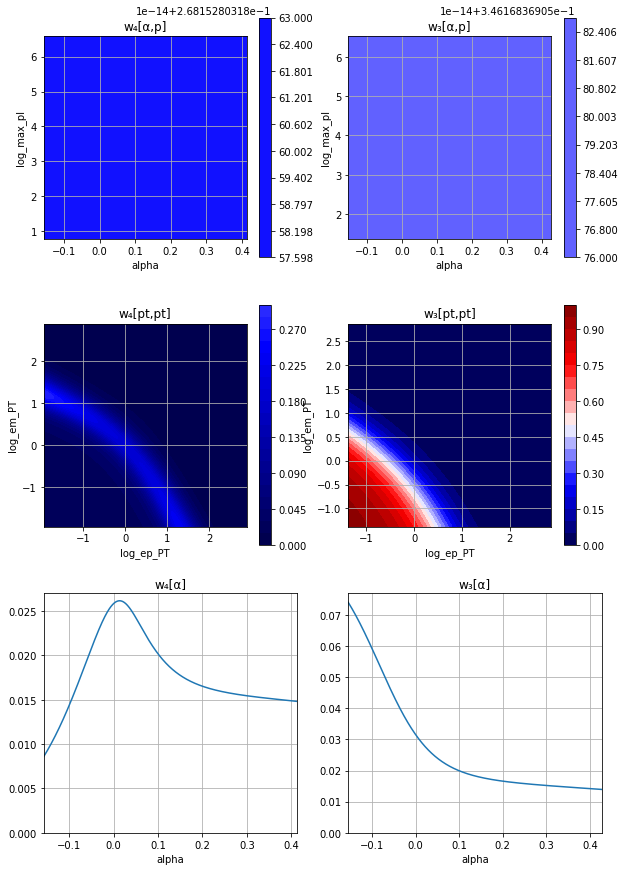

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, d in enumerate([w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3]):
    sc = d.model[0][0][0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i//2,i%2])
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i//2,i%2], vmax=None)
plt.show()

In [69]:
def quality(datasets, estimators, refname, name):
    df_w = pd.DataFrame()
    for w in estimators:
        name1 = "1-%s" % w.name
        r_name = "R[%s]" % w.name
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(w.model[0][0][0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),name1] = 1-torch.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    df_w.columns.name = name
    return df_w

In [70]:
quality(train_ds, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "train")

train           1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.731847        1.0  0.653832        1.0    0.948331   
B⁺→K⁺J/ψ(→ee)    0.731847        1.0  0.653832        1.0        0.98   
B⁺→K⁺ψ(2S)(→ee)  0.731847        1.0  0.653832        1.0    0.987946   
D⁺→π⁺φ(→ee)      0.731847        1.0  0.653832        1.0        0.93   

train           R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.033394    0.926684     1.057535  0.978616  1.001413   
B⁺→K⁺J/ψ(→ee)            1.0        0.98          1.0  0.979998       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.991957    0.985617     0.994301  0.980352   0.99964   
D⁺→π⁺φ(→ee)         1.053763    0.588263     1.665921  0.978781  1.001244   

train             1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.978375   1.00166  
B⁺→K⁺J/ψ(→ee)    0.979999       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.980388  0.999603  
D⁺→π⁺φ(→ee)      0.978607  1.001422

In [71]:
quality(test_ds, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "test")

test            1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.731847        1.0  0.653832        1.0    0.948412   
B⁺→K⁺J/ψ(→ee)    0.731847        1.0  0.653832        1.0    0.980064   
B⁺→K⁺ψ(2S)(→ee)  0.731847        1.0  0.653832        1.0     0.98793   
D⁺→π⁺φ(→ee)      0.731847        1.0  0.653832        1.0     0.92992   

test            R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee             1.033374    0.927435     1.056723  0.978607  1.001423   
B⁺→K⁺J/ψ(→ee)            1.0    0.980042          1.0  0.979999       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.992038    0.985577     0.994384  0.980353  0.999639   
D⁺→π⁺φ(→ee)         1.053923    0.589068     1.663716  0.978786  1.001239   

test              1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.978369  1.001667  
B⁺→K⁺J/ψ(→ee)        0.98       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.980391  0.999602  
D⁺→π⁺φ(→ee)      0.978609  1.001421

In [72]:
quality(selected, [w_la4, w_la3, w_pt4, w_pt3, w_a4, w_a3], channel_names[1], "all")

all             1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p] R[w₃[α,p]] 1-w₄[pt,pt]  \
B⁺→K⁺ee          0.731847        1.0  0.653832        1.0    0.948348   
B⁺→K⁺J/ψ(→ee)    0.731847        1.0  0.653832        1.0    0.980013   
B⁺→K⁺ψ(2S)(→ee)  0.731847        1.0  0.653832        1.0    0.987943   
D⁺→π⁺φ(→ee)      0.731847        1.0  0.653832        1.0    0.929984   

all             R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]   1-w₄[α]  R[w₄[α]]  \
B⁺→K⁺ee              1.03339    0.926834     1.057372  0.978614  1.001415   
B⁺→K⁺J/ψ(→ee)            1.0    0.980008          1.0  0.979998       1.0   
B⁺→K⁺ψ(2S)(→ee)     0.991973    0.985609     0.994318  0.980352  0.999639   
D⁺→π⁺φ(→ee)         1.053795    0.588424     1.665479  0.978782  1.001243   

all               1-w₃[α]  R[w₃[α]]  
B⁺→K⁺ee          0.978374  1.001661  
B⁺→K⁺J/ψ(→ee)    0.979999       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.980388  0.999603  
D⁺→π⁺φ(→ee)      0.978608  1.001422

### Conditional plots

In [79]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0][0][0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [80]:
def plot_e_all(feature, bins):
    fig, ax = plt.subplots(3, 2, figsize=(10, 15))
    plot_e(w_la4, feature, bins=bins, ax=ax[0,0])
    plot_e(w_la3, feature, bins=bins, ax=ax[0,1])
    plot_e(w_pt4, feature, bins=bins, ax=ax[1,0])
    plot_e(w_pt3, feature, bins=bins, ax=ax[1,1])
    plot_e(w_a4, feature, bins=bins, ax=ax[2,0])
    plot_e(w_a3, feature, bins=bins, ax=ax[2,1])
    plt.show()   

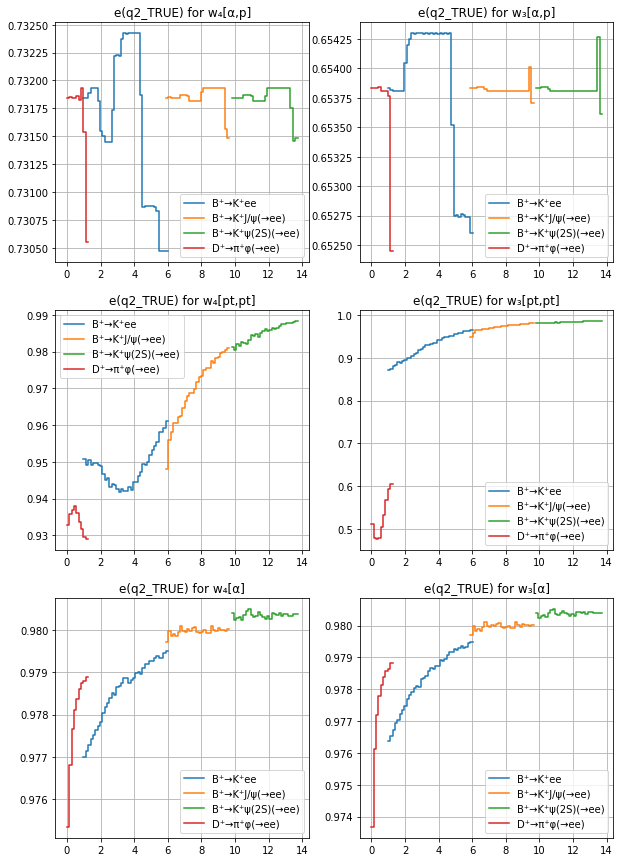

In [81]:
plot_e_all("q2_TRUE", np.linspace(0,14,101))

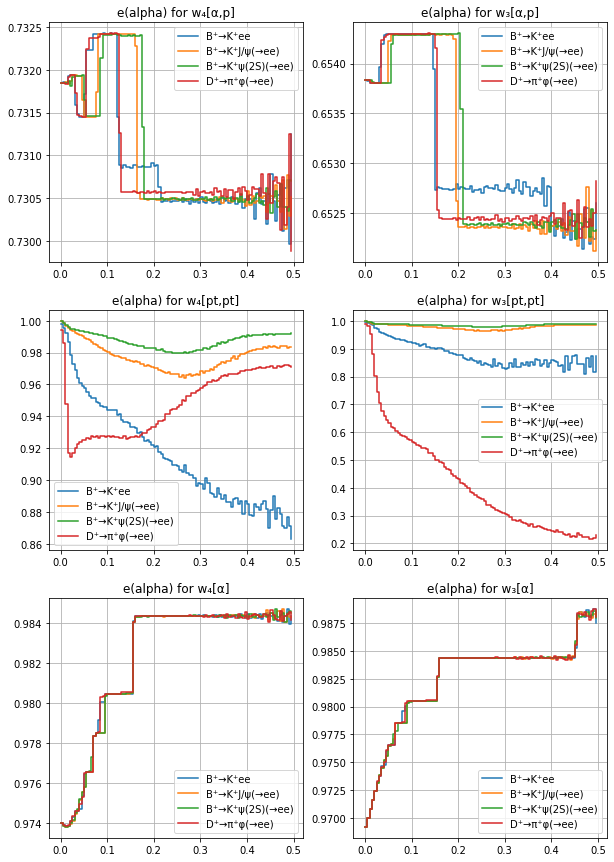

In [82]:
plot_e_all("alpha", np.linspace(0,0.5,101))

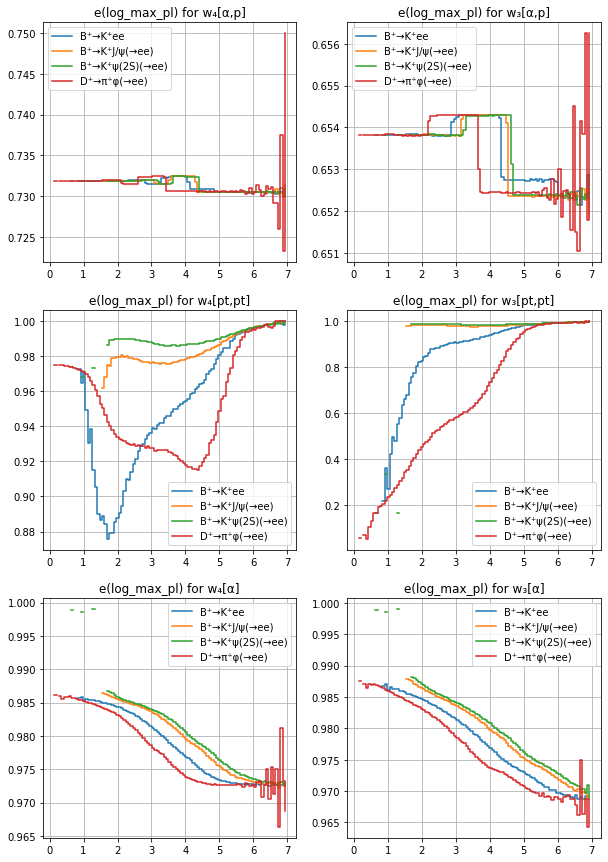

In [83]:
plot_e_all("log_max_pl", np.linspace(0,7,101))

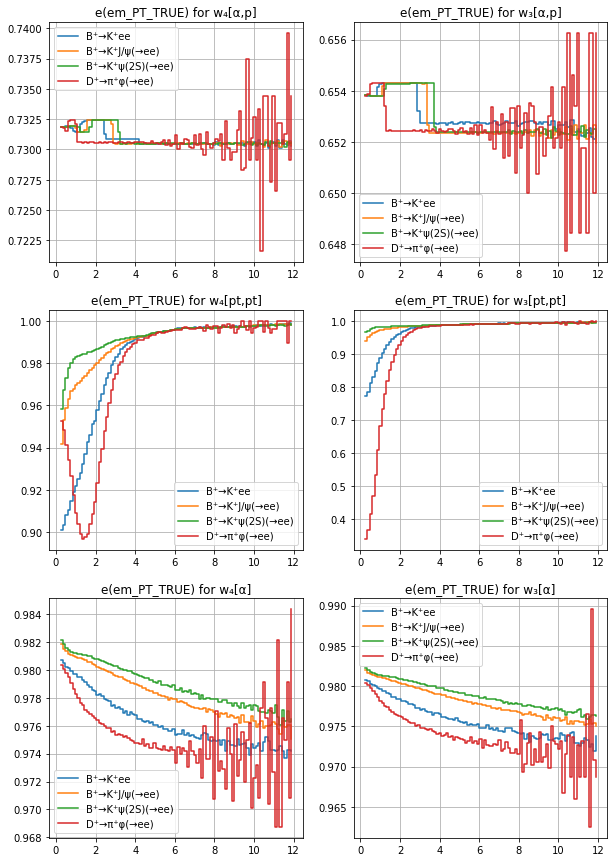

In [84]:
plot_e_all("em_PT_TRUE", np.linspace(0,12,101))

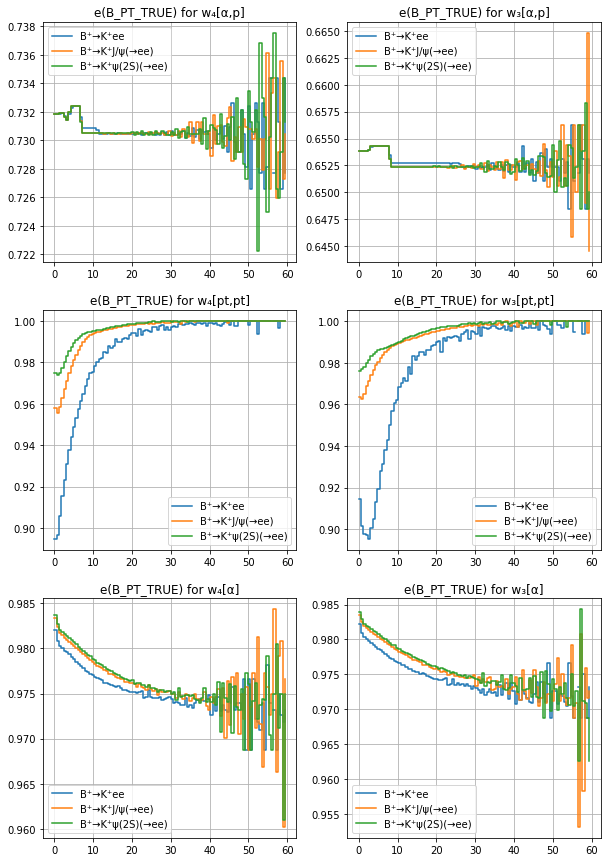

In [85]:
plot_e_all("B_PT_TRUE", np.linspace(0,60,101))

### Base estimators

In [86]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [87]:
def show_est(est, name):
    model = est.model.eval()
    scaler = est.scaler
    n_inputs = len(est.features)
    dummy = torch.zeros(1, n_inputs, dtype=float, device=device)
    n_outputs = model(dummy).shape[1]
    n2 = (n_outputs+1)//2
    w = nn.Sequential(model, torch.nn.Softmax(dim=-1))
    fig, ax = plt.subplots(2, n2, figsize=(10, n2*5))
    for i in range(n_outputs):
        plot_field(lambda x : as_numpy(w)(x)[...,i], scaler, name="%s[%d]"%(name, i), ax=ax[i//2,i%2])
    plt.show()

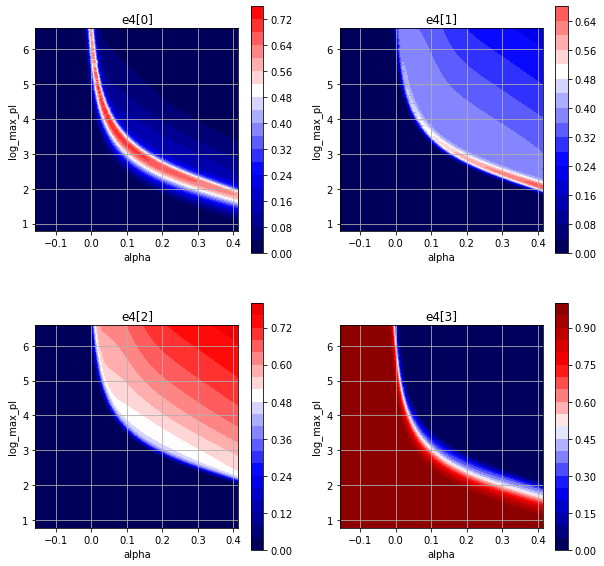

In [88]:
show_est(e_la4, "e4")

In [89]:
def show_fns(w):
    model = w.model.eval()
    scaler = model[0][0][0]
    w_ = as_numpy(model[0])
    n_inputs = len(scaler.features)
    dummy = torch.zeros(1, n_inputs, dtype=float, device=device)
    n_outputs = model[0](dummy).shape[1]
    n2 = (n_outputs+1)//2
    
    fig, ax = plt.subplots(2, n2, figsize=(10, n2*5))
    for i in range(n_outputs):
        plot_field(lambda x : w_(x)[...,i], scaler, name="%s[%d]"%(w.name, i), ax=ax[i//2,i%2])
    plt.show()

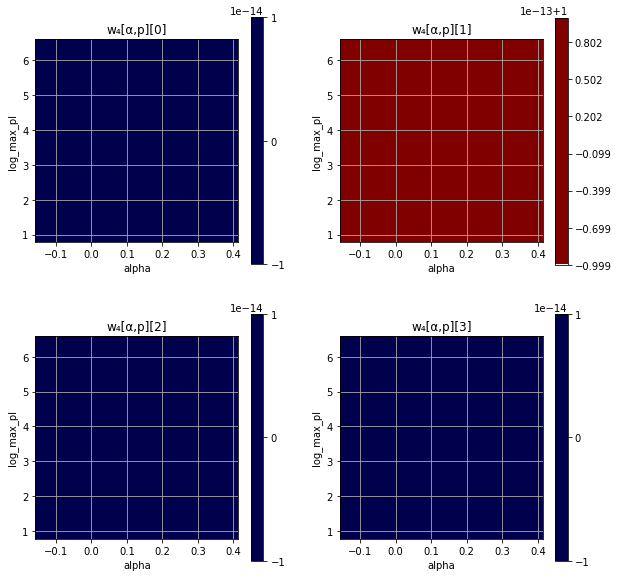

In [90]:
show_fns(w_la4)

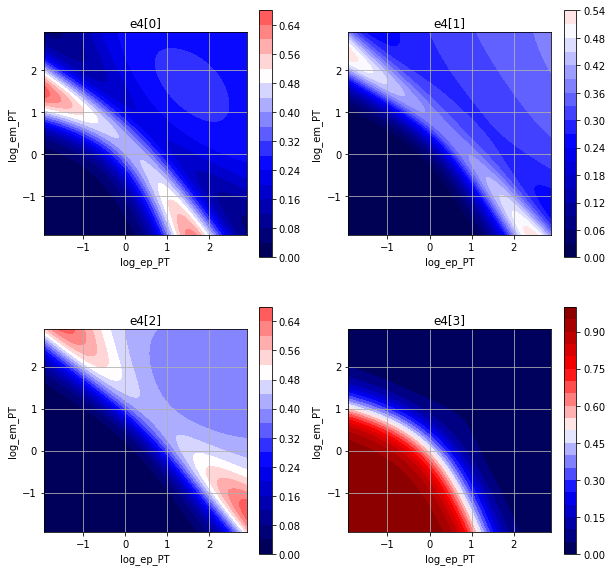

In [91]:
show_est(e_pt4, "e4")

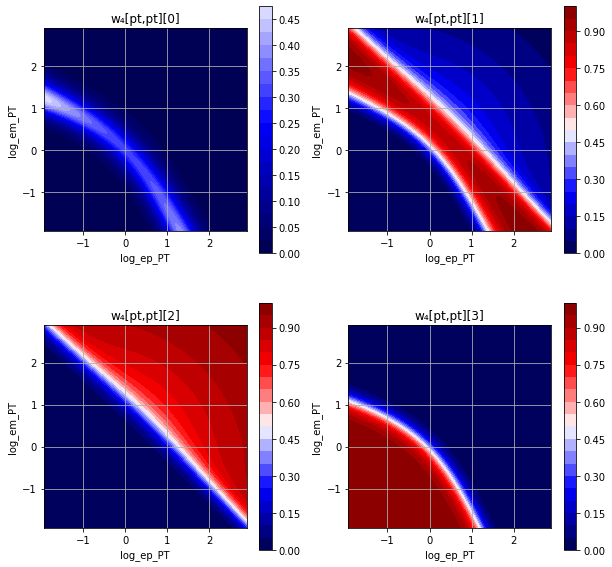

In [92]:
show_fns(w_pt4)